# Condition Monitoring of Air Pressure Systems (APS)

## Introduction

Large vehicles primarily rely on Air Pressure System (APS) as a means to control the brakes and gears. A failure in the APS can have fatal consequences for both the drivers and bystanders alike. And this is on top of the large monetary loss incurred whenever there is an unexpected breakdown. As such, trucking and bus companies would often try to do preventive maintenance beforehand, but being too proactive with this is still a costly endeavor. In this notebook we will apply several machine learning techniques to classify the condition of an APS system. In doing so we can:

1. Improve the reliability of the APS system by identifying predictors that of APS failures.
2. Reduce the losses associated with wrong predictive maintenance decisions.
3. Augment the resource management of technicians, mechanics, dispatchers and supply chain managers.

## Considerations

The dataset is an imbalanced binary classification problem where failures are rare occurences. There is an associated cost in for each wrong prediction that we must minimize; false positive and false negative are 10 Euros and 500 Euros respectively. One major limitation of this project is that the variables used have been masked as it is proprietary data. And so we cannot infer causality between the target variables and the features. Furthermore, all datapoints have at least 1 null value which can negatively impact the interpretability of the final model.

## Import Packages

In [1]:
import eif
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pickle as pkl
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from lightgbm import Dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random
from sklearn.metrics import precision_recall_curve
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as hac

## Define Functions

In [2]:
def apply_log(value):
    '''
    '''
    if np.isnan(value):
        return value
    else:
        return np.log1p(value)
    
def rescale(df):
    '''
    '''
    for col in df.columns:
        df[col] = df[col].apply(lambda x: apply_log(x))
    
    return df

def load_data(filename):
    '''
    '''
    df = pd.read_csv(filename)
    df = df.replace('na', np.nan)
    df = df.replace('neg', 0)
    df = df.replace('pos', 1)
    df = df.astype(float)
    print(df.shape)
    display(df.head())
    
    return df

def get_label(probability, thresh):
    '''
    '''
    if probability < thresh:
        return 0
    else:
        return 1
    
def estimate_hyperparameters(param_grid, x, y):
    '''
    '''
    cv_results = []
    for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):

        validation_summary = lgb.cv(hyperparams,
                                    Dataset(x, label=y),
                                    verbose_eval=25, seed=42)
        # Store the best hyperparameters
        cv_results.append((hyperparams, validation_summary["binary_logloss-mean"][-1]))
        
        print(validation_summary["binary_logloss-mean"][-1])
        print(hyperparams)
    return sorted(cv_results, key=lambda x: x[1], reverse=True)

def perform_splits(x,y,test_size=0.4, seed=42, n_splits=2):
    '''
    '''

    x_2_train , x_2_val, y_2_train, y_2_val = train_test_split(x, y,
                                                               test_size=test_size,
                                                               random_state=seed,
                                                               shuffle=True)

    x_2_train.columns = x.columns
    x_2_val.columns = x.columns

    # StratifiedKFold executes the k-fold operation in a stratified manner
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    skf.get_n_splits(x_2_val, y_2_val)

    # Get the validation sets
    val_inds = [tst for trn, tst in skf.split(x_2_val, y_2_val)]
    validation_sets = [Dataset(x_2_val.values[val_ind],
                               label=y_2_val.values[val_ind])
                       for val_ind in val_inds]
    
    return x_2_train , x_2_val, y_2_train, y_2_val, val_inds, validation_sets
    
def eval_prc(model, x_train, y_train,
             x_test, y_test):
    '''
    '''
    fig, ax = plt.subplots(figsize=(5,5), dpi=120)
    
    # Get scores for train set
    y_pred = model.predict(x_train)
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
    ax.plot(recall, precision, alpha=0.55, label=f'Train')
    
    # Get scores for test set
    y_pred = model.predict(x_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    ax.plot(recall, precision, alpha=0.55, label=f'Test')
    
    # Visualization of ROC

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR Curves')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid()
    ax.legend()

def eval_thresh_cost(model, x, y, title, cost_fp=10, cost_fn=500, custom_thresh=None):
    '''
    '''
    costs_fp = []
    costs_fn = []
    for thresh in np.linspace(0,50,51):
        y_pred = model.predict(x)
        ylabel = list(map(lambda x: get_label(x, thresh/100), y_pred))
        tn, fp, fn, tp = confusion_matrix(y, ylabel).ravel()
        costs_fp.append(fp*cost_fp)
        costs_fn.append(fn*cost_fn)
    total_cost = np.array(costs_fp)+np.array(costs_fn)

    if not custom_thresh:
        min_cost = min(total_cost)
        best_thresh = (np.linspace(0,50,51)/100)[total_cost.argmin()]
    else:
        best_i = list(np.linspace(0,50,51)/100).index(custom_thresh)
        best_thresh = (np.linspace(0,50,51)/100)[best_i]
        min_cost = total_cost[best_i]
        
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    print(min_cost, best_thresh)
    ax.plot(np.linspace(0,50,51)/100, costs_fp, label='False Positives Cost')
    ax.plot(np.linspace(0,50,51)/100, costs_fn, label='False Negative Cost')
    ax.plot(np.linspace(0,50,51)/100, total_cost, label=f'Total Cost (Cost: {min_cost} @ thresh: {best_thresh})')
    ax.set_ylabel('Cost (Euros)')
    ax.set_xlabel('Threshold')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.legend()
    ax.grid()
    
    if not custom_thresh:
        return best_thresh

## The Data

### Training Set

In [3]:
df_train = load_data('aps_failure_training_set.csv')

(60000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### Test Set

In [4]:
df_test = load_data('aps_failure_test_set.csv')

(16000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0.0,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0.0,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0.0,59816.0,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0.0,1814.0,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


## Exploratory Data Analysis and Cleaning

### Class Label Distribution

The target variable of the dataset is unbalanced as there are only 1000 instances of failure events out of 60000 samples. Since we are trying to minimize both the false positives and false negatives, precision and recall scores will be measured to evaluate the performance of the resulting model.

1000


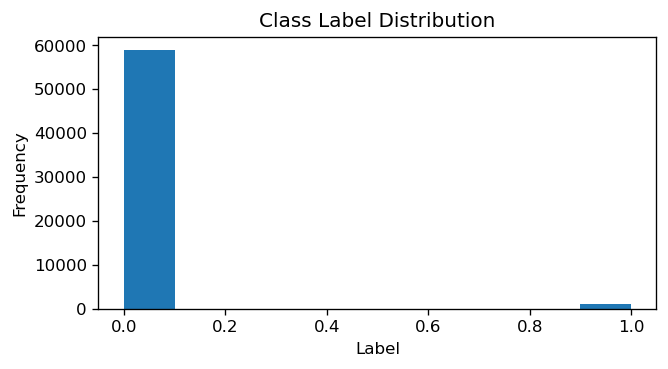

In [5]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
df_train['class'].hist(ax=ax)
ax.set_title('Class Label Distribution')
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.grid()
print(df_train[df_train['class']>0].shape[0])

### Null Handling

The data contains several null values, with some columns being comprised of more than 50% nulls. Imputing a variable that has a high percentage of unkown values could result to a misleading conclusion.

Text(0.5, 0, 'Percentage')

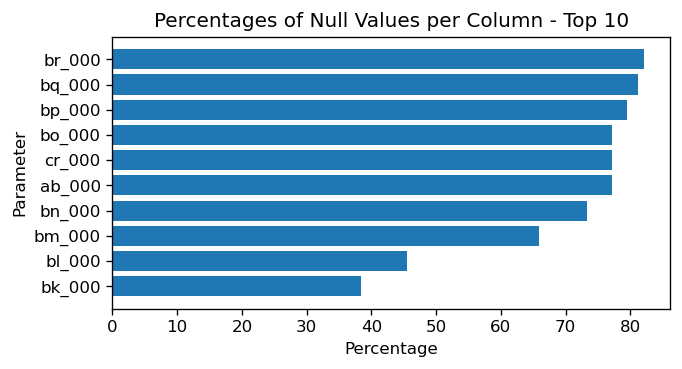

In [6]:
null_stats = (100*df_train.isnull().sum(axis=0)/df_train.shape[0]).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.barh(null_stats.iloc[-10:].index, null_stats.iloc[-10:])
ax.set_title('Percentages of Null Values per Column - Top 10')
ax.set_ylabel('Parameter')
ax.set_xlabel('Percentage')

However, if we were to drop rows / columns just because there are NaN values, we will be dropping a large chunk of our dataset.

In [7]:
print(df_train.dropna(how='any', axis=1).shape)
print(df_train.dropna(how='any').shape)

(60000, 2)
(591, 171)


We will opt for a hybrid of the two approaches. Rows and columns that exceed a certain threshold of null quantities will be dropped and the remaining nulls will be imputed. The code below shows the distribution of the null percentages along the rows and columns which will aid in identifying an appropriate threshold.

Text(0, 0.5, 'Frequency')

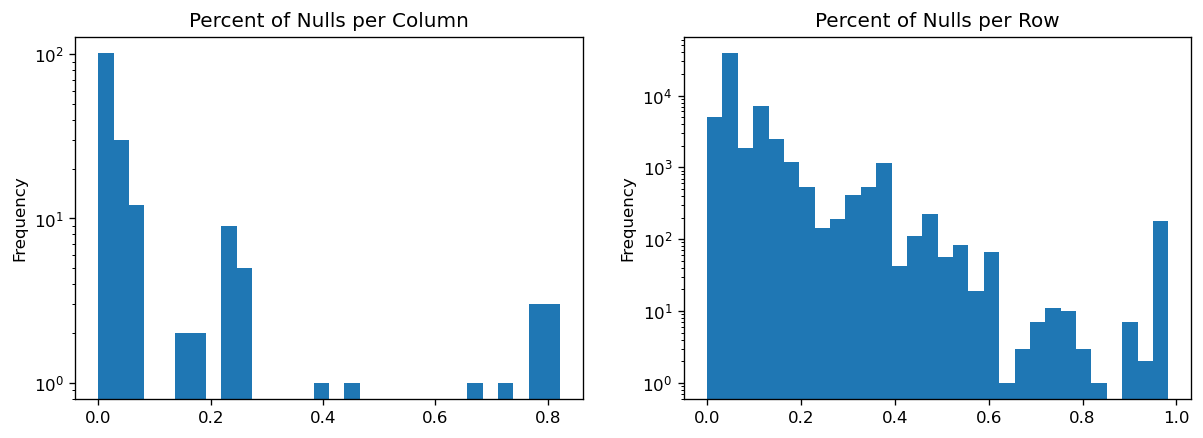

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
(df_train.isnull().sum(axis=0)/df_train.shape[0]).hist(bins=30, ax=ax[0])
(df_train.isnull().sum(axis=1)/df_train.shape[1]).hist(bins=30, ax=ax[1])
ax[0].set_title('Percent of Nulls per Column')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_ylabel('Frequency')
ax[1].set_title('Percent of Nulls per Row')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylabel('Frequency')

Columns and rows that contain more than 10% and 40% nulls respectively will be removed to reduce the amount of imputation needed. The end result is that we are left with `143` columns (inclusive of the target variable) along with `58329` (out of 59000) rows tagged as 0s and `995` (out of 1000) rows tagged as 1s.

In [9]:
df_cols3 = df_train.isnull().sum(axis=0)/df_train.shape[0]
df_cols3 = df_cols3[df_cols3<0.1]
len(df_cols3.index)

143

In [10]:
Counter(df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]['class'])

Counter({0.0: 58329, 1.0: 995})

In [11]:
df_train = df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]

### Check for Categorical or Continuous Variables

We must check if the variable is categorical or not so that we can apply the appropriate statistical tests. The code below counts the number of unique variables in a dataframe. The higher the count, the more likely it is to be a continuous variable and it seems that only `cd_0000` looks to be a categorical variable.

In [12]:
df_nunique = df_train.nunique(axis=0,
                              dropna=False).sort_values(ascending=True)
display(df_nunique.iloc[:10])

class      2
cd_000     2
as_000    21
ef_000    29
dz_000    48
eg_000    50
cs_009    53
au_000    57
ar_000    69
dj_000    73
dtype: int64

Checking `cd_0000` shows that it either has constant or a null value. We will drop this column from the modelling since it doesn't add any information due to it being a constant.

In [13]:
list(Counter(df_train['cd_000']).items())[:5]

[(1209600.0, 58842), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [14]:
df_train = df_train.drop('cd_000', axis=1)

### Check Distributions for Normality

Based on `D’Agostino’s K^2` test, it seems that none of our columns follow a normal distribution.

In [15]:
normality = []
for col in df_train.columns:
    
    k2, p = normaltest(df_train[col], nan_policy='omit')
    alpha = 0.05
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        normality.append((col, 'not normal'))
    else:
        normality.append((col, 'normal'))
        
print(f'First 15 columns:\n{normality[:15]}')

First 15 columns:
[('class', 'not normal'), ('aa_000', 'not normal'), ('ac_000', 'not normal'), ('ae_000', 'not normal'), ('af_000', 'not normal'), ('ag_000', 'not normal'), ('ag_001', 'not normal'), ('ag_002', 'not normal'), ('ag_003', 'not normal'), ('ag_004', 'not normal'), ('ag_005', 'not normal'), ('ag_006', 'not normal'), ('ag_007', 'not normal'), ('ag_008', 'not normal'), ('ag_009', 'not normal')]


### Visualization on a Subset of Columns

Majority, of the distributions follow a power law distribution wherein a few variables have very high values compared to the rest of the data. With this, it might be appropriate to use Spearman's correlation test in doing the feature selection.

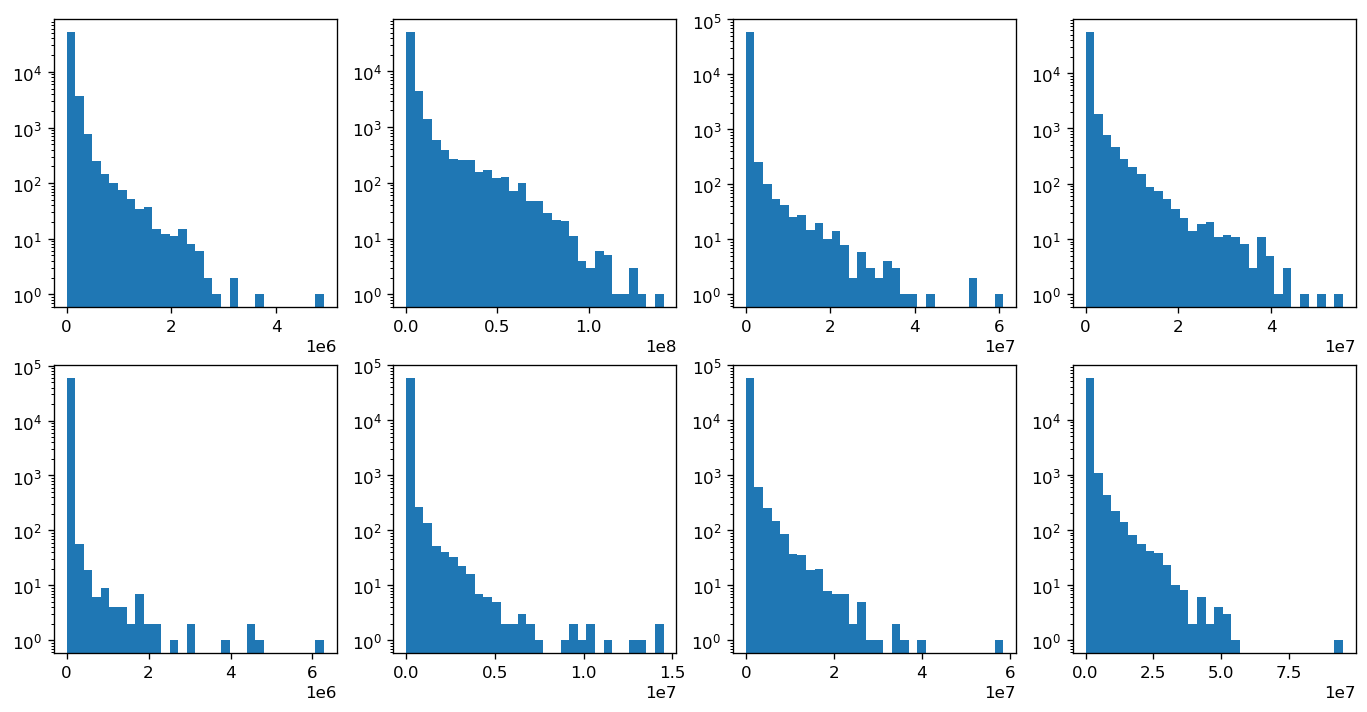

In [16]:
fig, ax = plt.subplots(2,4,figsize=(14,7), dpi=120)
for i, col in enumerate(df_train.columns[80:88]):
    if i < 4:
        j=0
    else:
        j=1
    df_train[col].hist(ax=ax[j][i%4], bins=30)
    ax[j][i%4].set_yscale('log')
    ax[j][i%4].grid()

## Imputing Nulls

Since the distribution follows a power law distribution, imputation will be done by using the mode of each distribution.

In [17]:
x = df_train[df_train.columns[1:]]
y = df_train['class']

imputer = SimpleImputer(strategy='most_frequent')
x = imputer.fit_transform(x)

## Outlier Analysis

Model performance can be negatively affected by outlying data points. As such it may be useful to analyze the outliers in the data set prior to modelling. Since the data is high dimensional (142 features) we will use an ML approach to checking for outliers.

Our chosen Outlier Detection approach is via the Extended Isolation Forest (EIF) algorithm (an improvement over Isolation Forest (IF)) which bisects the hyperplanes in multiple dimensions at each iteration. The idea of EIF is the same as IF wherein a datapoint's anomaly score is higher if it can be easily isolated from the rest of the datapoints. EIF solves the issues of imaginary dense clusters forming up in areas of low density. For more details on EIF you can check this paper: https://arxiv.org/pdf/1811.02141.pdf

A `sample_size` of 5000 was chosen to ensure that the distribution is somewhat preserved. The `number of tree estimators` was set to 125 to ensure that multiple subset of features will be explored by the model. Finally, an `ExtensionLevel` of 71 was chosen such that the model is bisecting the hyperplane 71 dimensions at a time (1/2 of all dimensions). Adding more extension levels does not necessarily improve performance, but it would certainly increase the computational complexity. By intersecting only half of all dimensions it gives the model some degree of freedom.

In [ ]:
eif_71 = eif.iForest(X, ntrees=125, sample_size=5000, ExtensionLevel=71)
anomaly_scores_71 = eif_71.compute_paths(X_in=X)

The frequency distribution of the anomaly scores can be seen below wherein the higher the score the more anomalous the datapoint is. The distribution is positively skewed. Most of the data points have an anomaly score around 0.40.

In [19]:
with open('anomaly_scores_71.pkl','rb') as f:
    anomaly_scores_71 = pkl.load(f)

Text(0.5, 0, 'Anomaly Score')

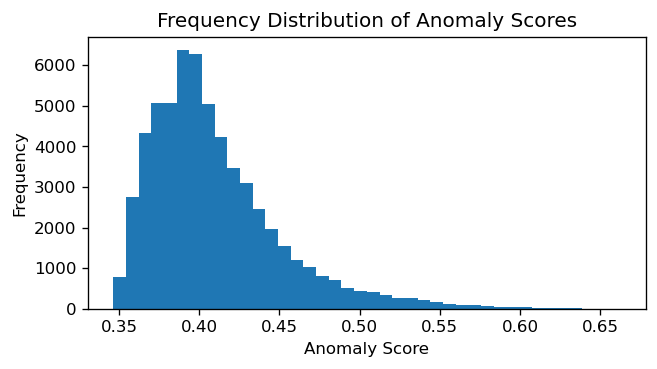

In [19]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.hist(anomaly_scores_71, bins=40)
ax.set_title('Frequency Distribution of Anomaly Scores')
ax.set_ylabel('Frequency')
ax.set_xlabel('Anomaly Score')

The code below extracts all the data points that go beyond an arbitrary outlier threshold that we define. **And it turns out that a large portion of our failure events are outlier cases. Infact, just by setting the threshold to 0.45, we are already able to capture 90% of the outlier cases.** In hindsight, this is expected because failure events are supposed to be outliers because if not, then the manufactured product (APS) would be downright unreliable.

In [20]:
Counter(y.values[np.where(anomaly_scores_71 > 0.413)])

Counter({0.0: 20793, 1.0: 965})

While EIF is able to capture a lot of the failure events, we also run the risk of having too many false positives. **If we are to use this model as it is, then more than 10% of our negative cases will be flagged.** Also, we have yet to determine which of these variables are actually relevant in identifying APS failures. A high anomaly score doesn't necessarily mean that it is a failure event, because the outlying feature may not even be related to the APS failure to begin with.

## Modelling

Several modelling experiments were attempted such as:
1. Stacking outlier detection with a model that can handle unbalanced classification (LGBM).
2. Classifying outlying points in the majority class vs the entire minority class.
3. Performing SMOTE prior to the classification to instead do binary classification.
4. Peforming feature selection and engineering (pairwise division of columns).
5. Performing feature selection and engineering then doing PCA.
6. Various scaling techniques.

However, only the best approach will be highlighted in this notebook from this point on.

## Feature Selection

We will rely on a combination of feature selection techniques, namely:
1. Embedded Feature Importance via tree-based algorithm (LGBM).
2. SHAPELY score (aka SHAP) using Game Theory.
3. Correlation testing with single linkage hierarchical clustering.
4. Backward Elimination (trial and error).

The steps is as follows:
1. Model the target variable using an algorithm that has an embedded feature importance function (e.g. tree based algo).
2. Maximize the performance of the model using all features.
3. Using the best model, get the SHAP score of each feature.
4. Filter out features that have very low SHAP score.
5. Get the correlation matrix of the remaining features.
6. Perform hierarchal clustering (using different thresholds) on the correlation matrix.
7. For each cluster at each threshold, select the most important feature based on SHAP score.

### Training and Test Set Preparation

The steps for the preparation are as follows:
1. Perform initial selection of relevant columns
2. Impute null values using the mode.
3. Perform log-scaling.
4. Perform min-max scaling.

For the training set, steps 1 and 2 have already been done in the previous sections of this notebook. For the test set, imputation and min-max scaling will be done using the already fitted imputer and scaler which was fitted on the training set.Le

In [18]:
x = pd.DataFrame(x, columns=df_train.columns[1:])
x = rescale(x)

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x, columns=df_train.columns[1:])

x_test = df_test[df_train.columns[1:]]
x_test = imputer.transform(x_test)
x_test = pd.DataFrame(x_test, columns=df_train.columns[1:])
# No droping of rows with many null values
x_test = rescale(x_test)
x_test = scaler.transform(x_test)

x_test = pd.DataFrame(x_test)
x_test.columns = df_train.columns[1:]

# No outlier analysis / inlier removal
y_test = df_test['class']

### Hyperparameter Tuning

Several hyperparameters were tried and tested using the built in cross validation function of LGBM. The best performing hyperparameters (along with the score) are stored in `cv_results`. Which will be saved to allow ease of re-training the model.

In [66]:
param_grid = {'num_leaves': [50,60],
              'min_data_in_leaf': [150,300],
              'lambda_l1': [0.00001,0.0001],
              'lambda_l2': [10,50],
              'bagging_fraction':[0.75],
              'bagging_freq':[2], 'max_depth':[6],
              'pos_bagging_fraction':[0.1],
              'neg_bagging_fraction':[0.75],
              'objective':['binary'],'path_smooth':[2],
              'min_gain_to_split':[0.3,0.4],
              'learning_rate':[0.1],
              'num_boost_round':[1500],
              'nfold':[5], 'is_unbalance':[True],
              'early_stopping_rounds':[10]}

cv_results = estimate_hyperparameters(param_grid, x, y)
# cv_results = estimate_hyperparameters(param_grid, x_sm, y_sm)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355281 + 0.00123852
[50]	cv_agg's binary_logloss: 0.0293026 + 0.000802305
[75]	cv_agg's binary_logloss: 0.026242 + 0.000826291
[100]	cv_agg's binary_logloss: 0.0251896 + 0.00143356
[125]	cv_agg's binary_logloss: 0.0249114 + 0.00120491
0.024876296996778402
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355281 + 0.00123852
[50]	cv_agg's binary_logloss: 0.0293026 + 0.000802305
[75]	cv_agg's binary_logloss: 0.026242 + 0.000826291
[100]	cv_agg's binary_logloss: 0.0251896 + 0.00143356
[125]	cv_agg's binary_logloss: 0.0249114 + 0.00120491
0.024876296996778402
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355118 + 0.00122736
[50]	cv_agg's binary_logloss: 0.0290573 + 0.000657816
[75]	cv_agg's binary_logloss: 0.0261581 + 0.000798233
[100]	cv_agg's binary_logloss: 0.0246377 + 0.0011714
[125]	cv_agg's binary_logloss: 0.0242374 + 0.00134855
[150]	cv_agg's binary_logloss: 0.0234288 + 0.00160176
0.023403724517865338
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355118 + 0.00122736
[50]	cv_agg's binary_logloss: 0.0290573 + 0.000657816
[75]	cv_agg's binary_logloss: 0.0261581 + 0.000798233
[100]	cv_agg's binary_logloss: 0.0246377 + 0.0011714
[125]	cv_agg's binary_logloss: 0.0242374 + 0.00134855
[150]	cv_agg's binary_logloss: 0.0234288 + 0.00160176
0.023403724517865338
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819106
[50]	cv_agg's binary_logloss: 0.0326699 + 0.00122861
[75]	cv_agg's binary_logloss: 0.0291587 + 0.00145455
[100]	cv_agg's binary_logloss: 0.0279478 + 0.0020537
[125]	cv_agg's binary_logloss: 0.0268492 + 0.00162564
[150]	cv_agg's binary_logloss: 0.0260427 + 0.00209178
[175]	cv_agg's binary_logloss: 0.0255787 + 0.00181337
0.025357375493772046
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819106
[50]	cv_agg's binary_logloss: 0.0326699 + 0.00122861
[75]	cv_agg's binary_logloss: 0.0291587 + 0.00145455
[100]	cv_agg's binary_logloss: 0.0279478 + 0.0020537
[125]	cv_agg's binary_logloss: 0.0268492 + 0.00162564
[150]	cv_agg's binary_logloss: 0.0260427 + 0.00209178
[175]	cv_agg's binary_logloss: 0.0255787 + 0.00181337
0.025357375493772046
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819106
[50]	cv_agg's binary_logloss: 0.0326693 + 0.00122773
[75]	cv_agg's binary_logloss: 0.0290906 + 0.00142455
[100]	cv_agg's binary_logloss: 0.0278826 + 0.00207703
[125]	cv_agg's binary_logloss: 0.0267165 + 0.00170617
[150]	cv_agg's binary_logloss: 0.0262466 + 0.00236319
[175]	cv_agg's binary_logloss: 0.025679 + 0.00168268
0.025534135052849478
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819106
[50]	cv_agg's binary_logloss: 0.0326693 + 0.00122773
[75]	cv_agg's binary_logloss: 0.0290906 + 0.00142455
[100]	cv_agg's binary_logloss: 0.0278826 + 0.00207703
[125]	cv_agg's binary_logloss: 0.0267165 + 0.00170617
[150]	cv_agg's binary_logloss: 0.0262466 + 0.00236319
[175]	cv_agg's binary_logloss: 0.025679 + 0.00168268
0.025534135052849478
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327959 + 0.00130844
[75]	cv_agg's binary_logloss: 0.0297036 + 0.00131279
[100]	cv_agg's binary_logloss: 0.0277604 + 0.00164253
[125]	cv_agg's binary_logloss: 0.0261418 + 0.00130137
[150]	cv_agg's binary_logloss: 0.0255312 + 0.00153719
[175]	cv_agg's binary_logloss: 0.0250164 + 0.00146658
0.024948846117874575
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327959 + 0.00130844
[75]	cv_agg's binary_logloss: 0.0297036 + 0.00131279
[100]	cv_agg's binary_logloss: 0.0277604 + 0.00164253
[125]	cv_agg's binary_logloss: 0.0261418 + 0.00130137
[150]	cv_agg's binary_logloss: 0.0255312 + 0.00153719
[175]	cv_agg's binary_logloss: 0.0250164 + 0.00146658
0.024948846117874575
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327208 + 0.00121331
[75]	cv_agg's binary_logloss: 0.029549 + 0.00134257
[100]	cv_agg's binary_logloss: 0.0279657 + 0.00186074
[125]	cv_agg's binary_logloss: 0.0269034 + 0.00117806
[150]	cv_agg's binary_logloss: 0.0262772 + 0.00146165
[175]	cv_agg's binary_logloss: 0.0257117 + 0.00142559
0.025657059959437834
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327208 + 0.00121331
[75]	cv_agg's binary_logloss: 0.029549 + 0.00134257
[100]	cv_agg's binary_logloss: 0.0279657 + 0.00186074
[125]	cv_agg's binary_logloss: 0.0269034 + 0.00117806
[150]	cv_agg's binary_logloss: 0.0262772 + 0.00146165
[175]	cv_agg's binary_logloss: 0.0257117 + 0.00142559
0.025657059959437834
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0404187 + 0.00133476
[50]	cv_agg's binary_logloss: 0.0355554 + 0.00118084
[75]	cv_agg's binary_logloss: 0.0321762 + 0.00117633
[100]	cv_agg's binary_logloss: 0.0300237 + 0.00154553
[125]	cv_agg's binary_logloss: 0.0286992 + 0.00143008
[150]	cv_agg's binary_logloss: 0.0277957 + 0.00159388
[175]	cv_agg's binary_logloss: 0.0271002 + 0.00114963
[200]	cv_agg's binary_logloss: 0.0264776 + 0.00123771
[225]	cv_agg's binary_logloss: 0.0257208 + 0.00152939
[250]	cv_agg's binary_logloss: 0.0251704 + 0.00173886
[275]	cv_agg's binary_logloss: 0.0247214 + 0.00170455
0.0246905466851213
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0404187 + 0.00133476
[50]	cv_agg's binary_logloss: 0.0355554 + 0.00118084
[75]	cv_agg's binary_logloss: 0.0321762 + 0.00117633
[100]	cv_agg's binary_logloss: 0.0300237 + 0.00154553
[125]	cv_agg's binary_logloss: 0.0286992 + 0.00143008
[150]	cv_agg's binary_logloss: 0.0277957 + 0.00159388
[175]	cv_agg's binary_logloss: 0.0271002 + 0.00114963
[200]	cv_agg's binary_logloss: 0.0264776 + 0.00123771
[225]	cv_agg's binary_logloss: 0.0257208 + 0.00152939
[250]	cv_agg's binary_logloss: 0.0251704 + 0.00173886
[275]	cv_agg's binary_logloss: 0.0247214 + 0.00170455
0.0246905466851213
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0403746 + 0.00138241
[50]	cv_agg's binary_logloss: 0.0356553 + 0.00112996
[75]	cv_agg's binary_logloss: 0.0319923 + 0.00105191
[100]	cv_agg's binary_logloss: 0.0300434 + 0.00154916
[125]	cv_agg's binary_logloss: 0.0286152 + 0.00146222
[150]	cv_agg's binary_logloss: 0.0274929 + 0.00166997
[175]	cv_agg's binary_logloss: 0.027077 + 0.00121269
[200]	cv_agg's binary_logloss: 0.0263238 + 0.00136858
[225]	cv_agg's binary_logloss: 0.0254808 + 0.00139539
[250]	cv_agg's binary_logloss: 0.0249913 + 0.00169105
0.024991315245272254
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0403746 + 0.00138241
[50]	cv_agg's binary_logloss: 0.0356553 + 0.00112996
[75]	cv_agg's binary_logloss: 0.0319923 + 0.00105191
[100]	cv_agg's binary_logloss: 0.0300434 + 0.00154916
[125]	cv_agg's binary_logloss: 0.0286152 + 0.00146222
[150]	cv_agg's binary_logloss: 0.0274929 + 0.00166997
[175]	cv_agg's binary_logloss: 0.027077 + 0.00121269
[200]	cv_agg's binary_logloss: 0.0263238 + 0.00136858
[225]	cv_agg's binary_logloss: 0.0254808 + 0.00139539
[250]	cv_agg's binary_logloss: 0.0249913 + 0.00169105
0.024991315245272254
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355281 + 0.00123852
[50]	cv_agg's binary_logloss: 0.0293026 + 0.000802304
[75]	cv_agg's binary_logloss: 0.026242 + 0.000826287
[100]	cv_agg's binary_logloss: 0.0251896 + 0.00143356
[125]	cv_agg's binary_logloss: 0.0249114 + 0.0012049
0.02487629669019779
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355281 + 0.00123852
[50]	cv_agg's binary_logloss: 0.0293026 + 0.000802304
[75]	cv_agg's binary_logloss: 0.026242 + 0.000826287
[100]	cv_agg's binary_logloss: 0.0251896 + 0.00143356
[125]	cv_agg's binary_logloss: 0.0249114 + 0.0012049
0.02487629669019779
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355118 + 0.00122736
[50]	cv_agg's binary_logloss: 0.0290573 + 0.000657815
[75]	cv_agg's binary_logloss: 0.0261581 + 0.00079823
[100]	cv_agg's binary_logloss: 0.0246377 + 0.0011714
[125]	cv_agg's binary_logloss: 0.0242374 + 0.00134855
[150]	cv_agg's binary_logloss: 0.0234288 + 0.00160175
0.02340371711398935
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0355118 + 0.00122736
[50]	cv_agg's binary_logloss: 0.0290573 + 0.000657815
[75]	cv_agg's binary_logloss: 0.0261581 + 0.00079823
[100]	cv_agg's binary_logloss: 0.0246377 + 0.0011714
[125]	cv_agg's binary_logloss: 0.0242374 + 0.00134855
[150]	cv_agg's binary_logloss: 0.0234288 + 0.00160175
0.02340371711398935
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819105
[50]	cv_agg's binary_logloss: 0.0326699 + 0.00122861
[75]	cv_agg's binary_logloss: 0.0291587 + 0.00145455
[100]	cv_agg's binary_logloss: 0.0279478 + 0.0020537
[125]	cv_agg's binary_logloss: 0.0268492 + 0.00162563
[150]	cv_agg's binary_logloss: 0.0260427 + 0.00209177
[175]	cv_agg's binary_logloss: 0.0255787 + 0.00181336
0.025357370492506952
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819105
[50]	cv_agg's binary_logloss: 0.0326699 + 0.00122861
[75]	cv_agg's binary_logloss: 0.0291587 + 0.00145455
[100]	cv_agg's binary_logloss: 0.0279478 + 0.0020537
[125]	cv_agg's binary_logloss: 0.0268492 + 0.00162563
[150]	cv_agg's binary_logloss: 0.0260427 + 0.00209177
[175]	cv_agg's binary_logloss: 0.0255787 + 0.00181336
0.025357370492506952
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819105
[50]	cv_agg's binary_logloss: 0.0326693 + 0.00122773
[75]	cv_agg's binary_logloss: 0.0290906 + 0.00142454
[100]	cv_agg's binary_logloss: 0.0278826 + 0.00207702
[125]	cv_agg's binary_logloss: 0.0267165 + 0.00170616
[150]	cv_agg's binary_logloss: 0.0262466 + 0.00236318
[175]	cv_agg's binary_logloss: 0.025679 + 0.00168267
0.025534130113758345
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0397629 + 0.000819105
[50]	cv_agg's binary_logloss: 0.0326693 + 0.00122773
[75]	cv_agg's binary_logloss: 0.0290906 + 0.00142454
[100]	cv_agg's binary_logloss: 0.0278826 + 0.00207702
[125]	cv_agg's binary_logloss: 0.0267165 + 0.00170616
[150]	cv_agg's binary_logloss: 0.0262466 + 0.00236318
[175]	cv_agg's binary_logloss: 0.025679 + 0.00168267
0.025534130113758345
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327959 + 0.00130844
[75]	cv_agg's binary_logloss: 0.0297036 + 0.00131279
[100]	cv_agg's binary_logloss: 0.0277604 + 0.00164253
[125]	cv_agg's binary_logloss: 0.0261418 + 0.00130137
[150]	cv_agg's binary_logloss: 0.0255312 + 0.00153718
[175]	cv_agg's binary_logloss: 0.0250164 + 0.00146658
0.024948851486770098
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327959 + 0.00130844
[75]	cv_agg's binary_logloss: 0.0297036 + 0.00131279
[100]	cv_agg's binary_logloss: 0.0277604 + 0.00164253
[125]	cv_agg's binary_logloss: 0.0261418 + 0.00130137
[150]	cv_agg's binary_logloss: 0.0255312 + 0.00153718
[175]	cv_agg's binary_logloss: 0.0250164 + 0.00146658
0.024948851486770098
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327208 + 0.00121331
[75]	cv_agg's binary_logloss: 0.0295491 + 0.00134257
[100]	cv_agg's binary_logloss: 0.0279657 + 0.00186074
[125]	cv_agg's binary_logloss: 0.0269034 + 0.00117806
[150]	cv_agg's binary_logloss: 0.0262772 + 0.00146165
[175]	cv_agg's binary_logloss: 0.0257117 + 0.00142559
0.025657065670612305
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0374886 + 0.00142119
[50]	cv_agg's binary_logloss: 0.0327208 + 0.00121331
[75]	cv_agg's binary_logloss: 0.0295491 + 0.00134257
[100]	cv_agg's binary_logloss: 0.0279657 + 0.00186074
[125]	cv_agg's binary_logloss: 0.0269034 + 0.00117806
[150]	cv_agg's binary_logloss: 0.0262772 + 0.00146165
[175]	cv_agg's binary_logloss: 0.0257117 + 0.00142559
0.025657065670612305
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0404187 + 0.00133476
[50]	cv_agg's binary_logloss: 0.0355555 + 0.00118084
[75]	cv_agg's binary_logloss: 0.0321762 + 0.00117633
[100]	cv_agg's binary_logloss: 0.0300237 + 0.00154553
[125]	cv_agg's binary_logloss: 0.0286992 + 0.00143007
[150]	cv_agg's binary_logloss: 0.0277957 + 0.00159388
[175]	cv_agg's binary_logloss: 0.0271002 + 0.00114963
[200]	cv_agg's binary_logloss: 0.0264776 + 0.00123771
[225]	cv_agg's binary_logloss: 0.0257208 + 0.00152939
[250]	cv_agg's binary_logloss: 0.0251704 + 0.00173886
[275]	cv_agg's binary_logloss: 0.0247214 + 0.00170454
0.02469054969649274
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0404187 + 0.00133476
[50]	cv_agg's binary_logloss: 0.0355555 + 0.00118084
[75]	cv_agg's binary_logloss: 0.0321762 + 0.00117633
[100]	cv_agg's binary_logloss: 0.0300237 + 0.00154553
[125]	cv_agg's binary_logloss: 0.0286992 + 0.00143007
[150]	cv_agg's binary_logloss: 0.0277957 + 0.00159388
[175]	cv_agg's binary_logloss: 0.0271002 + 0.00114963
[200]	cv_agg's binary_logloss: 0.0264776 + 0.00123771
[225]	cv_agg's binary_logloss: 0.0257208 + 0.00152939
[250]	cv_agg's binary_logloss: 0.0251704 + 0.00173886
[275]	cv_agg's binary_logloss: 0.0247214 + 0.00170454
0.02469054969649274
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0403746 + 0.00138241
[50]	cv_agg's binary_logloss: 0.0356554 + 0.00112996
[75]	cv_agg's binary_logloss: 0.0319923 + 0.00105191
[100]	cv_agg's binary_logloss: 0.0300434 + 0.00154916
[125]	cv_agg's binary_logloss: 0.0286152 + 0.00146222
[150]	cv_agg's binary_logloss: 0.0274929 + 0.00166996
[175]	cv_agg's binary_logloss: 0.027077 + 0.00121269
[200]	cv_agg's binary_logloss: 0.0263238 + 0.00136858
[225]	cv_agg's binary_logloss: 0.0254809 + 0.00139538
[250]	cv_agg's binary_logloss: 0.0249913 + 0.00169105
0.02499131818523805
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0403746 + 0.00138241
[50]	cv_agg's binary_logloss: 0.0356554 + 0.00112996
[75]	cv_agg's binary_logloss: 0.0319923 + 0.00105191
[100]	cv_agg's binary_logloss: 0.0300434 + 0.00154916
[125]	cv_agg's binary_logloss: 0.0286152 + 0.00146222
[150]	cv_agg's binary_logloss: 0.0274929 + 0.00166996
[175]	cv_agg's binary_logloss: 0.027077 + 0.00121269
[200]	cv_agg's binary_logloss: 0.0263238 + 0.00136858
[225]	cv_agg's binary_logloss: 0.0254809 + 0.00139538
[250]	cv_agg's binary_logloss: 0.0249913 + 0.00169105
0.02499131818523805
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 300, 'min_gain_to_split': 0.4, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 60, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.1}


#### Save Hyperparameters

In [19]:
with open('cv.pkl', 'wb') as f:
    pkl.dump(cv_results, f)
with open('cv.pkl', 'rb') as f:
    cv_results = pkl.load(f)

The model will be trained using the best hyperparameters.

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  shuffle=True)
x_train = pd.DataFrame(x_train, columns=df_train.columns[1:])

params = cv_results[-1][0]
params['metric'] = ['']
# Model
lgbm_model = lgb.train(params, Dataset(x_train, label=y_train),
                       valid_sets=Dataset(x_val, label=y_val),
                       verbose_eval=25)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
[25]	valid_0's binary_logloss: 0.0348776
[50]	valid_0's binary_logloss: 0.028575
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.0272701


### PR Curve

`Precision` measures how much of the predicted failure events are actually failure events, whereas `Recall` measures how much of the failure events were actually captured. We want to maximize both, as such the best model will be the wherein both the train and test PR Curves are close to the upper right corner of the plot.

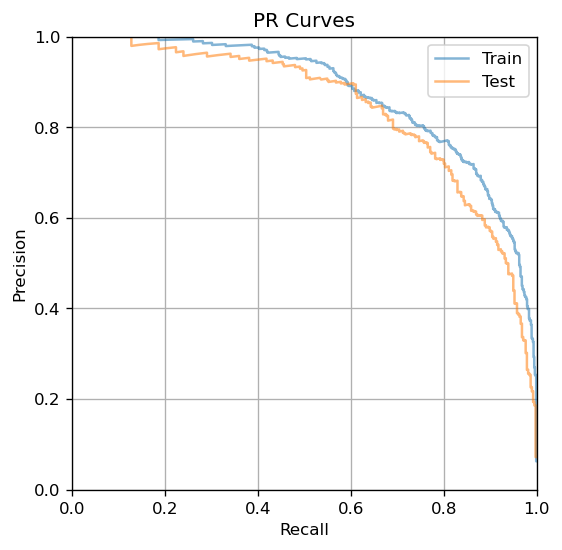

In [70]:
eval_prc(lgbm_model,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test)

### Threshold and Associated Cost

The model gives a score in between 0 and 1, any data point that has a score of at least 0.01 will be flagged as a failure event. With this, we are able to minimize the cost of maintaining the APS system to just 12050 Euros. However, this isn't the final model as there are features that are not relevant to the failure event.

12050 0.01


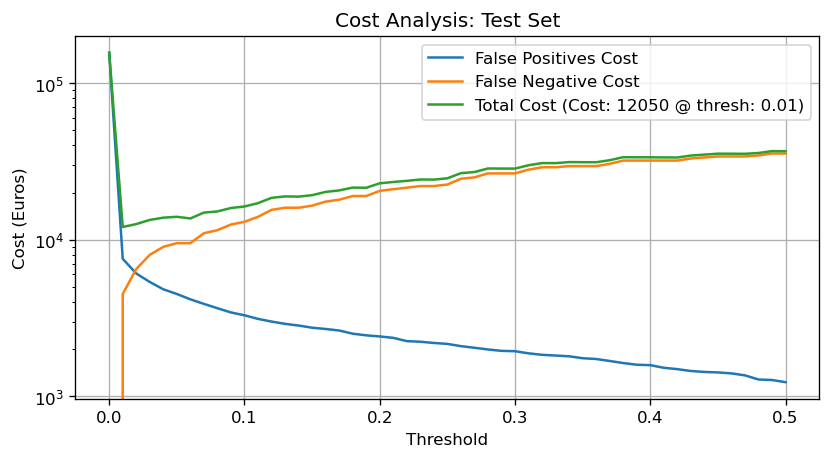

In [72]:
eval_thresh_cost(lgbm_model,
                 x=x_test,
                 y=y_test,
                 title='Cost Analysis: Test Set',
                 custom_thresh=0.01)

## SHAP Feature Importance

We will rely on SHAP to explain the performance of our LGBM model. The code below highlights the top 20 most relevant features based on their SHAP value. The color of the points gives a hint at the value of each variable (high or low). Note that we will still need to view the actual distribution to get a better understanding of the system's behavior.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


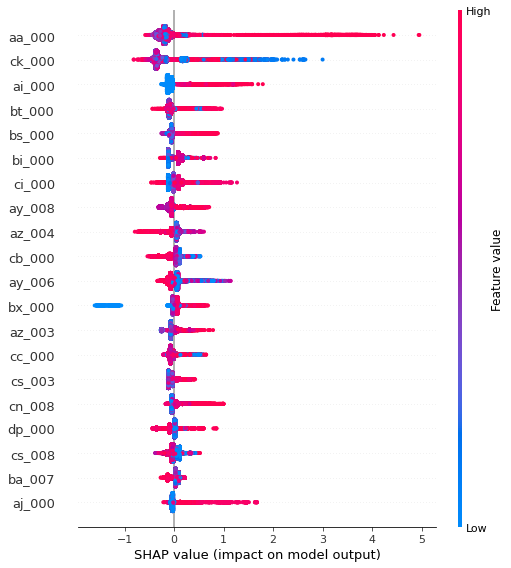

In [191]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[1], x_train)

The code below shows how important each feature is based on their SHAP value. Checking the distribution, we see that there are several features that don't really impact the final prediction.

,col_name,feature_importance_vals
0,aa_000,0.370678
82,ck_000,0.322709
15,ai_000,0.131234
70,bt_000,0.112057
69,bs_000,0.111987
...,...,...
109,dh_000,0.000000
111,dj_000,0.000000
112,dk_000,0.000000
113,dl_000,0.000000


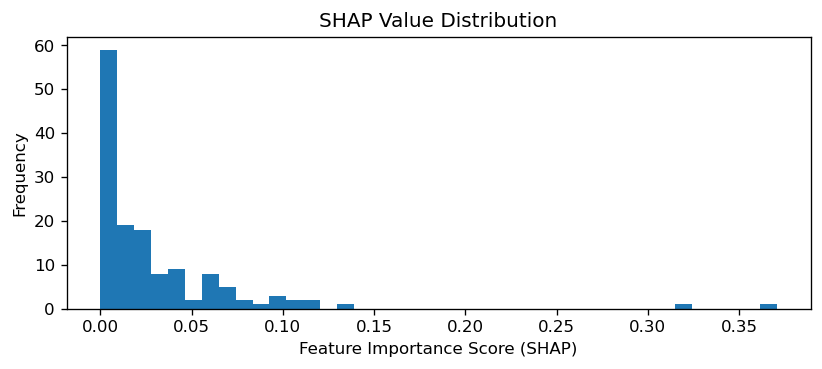

In [32]:
vals= np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(df_train.columns[1:],vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
display(feature_importance)

fig, ax = plt.subplots(figsize=(8,3), dpi=120)
feature_importance['feature_importance_vals'].plot(kind='hist', bins=40, ax=ax);
ax.set_title('SHAP Value Distribution')
ax.set_xlabel('Feature Importance Score (SHAP)');

The code below shows the cummulative distribution of the SHAP scores. We will use this to set a threshold to determine which features are important for this modelling application. It seems that the SHAP scores start to plateau by ranks 80 - 100. 

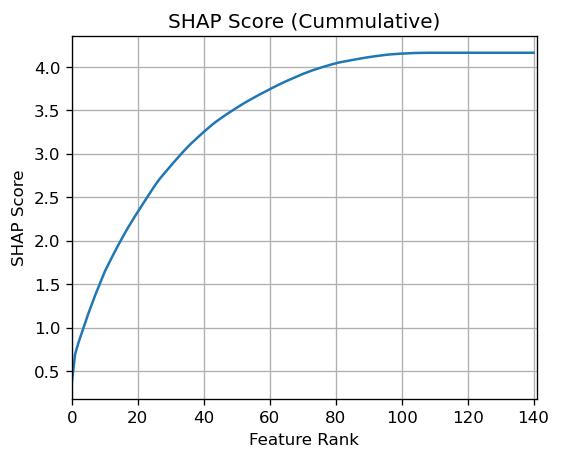

In [55]:
fig, ax = plt.subplots(figsize=(5,4), dpi=120)
ax.plot((feature_importance['feature_importance_vals']).cumsum().reset_index(drop=True))
ax.set_title('SHAP Score (Cummulative)')
ax.grid()
ax.set_xlim(0,141);
ax.set_ylabel('SHAP Score')
ax.set_xlabel('Feature Rank');

### SHAP Value Distribution per Top Predictor

The code below shows the distribution of the SHAP values for each of the top 10 most relevant features. It can clearly be seen that above a certain point the SHAP value suddenly rises / falls. This is a common phenomenon in failure analysis, wherein a device functions normally but suddenly breaksdown when a parameter (e.g. temperature, pressure) goes above or below a certain point. It is highly likely that some of the False Positives are simply points that are very near the breakdown point.

**Unfortunately, we won't be able to do a deep dive on what each feature means since they've been masked.**

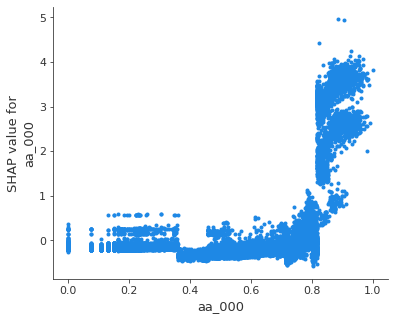

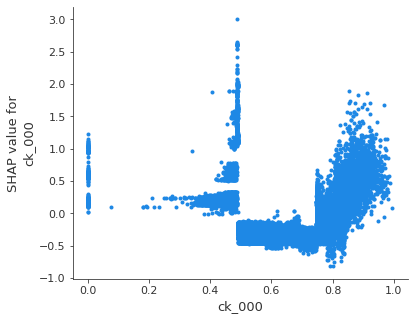

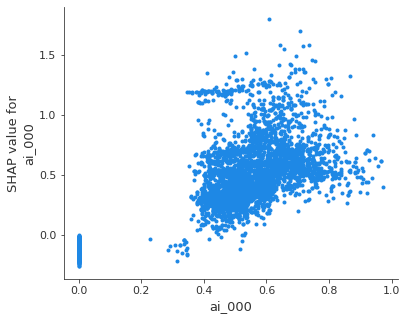

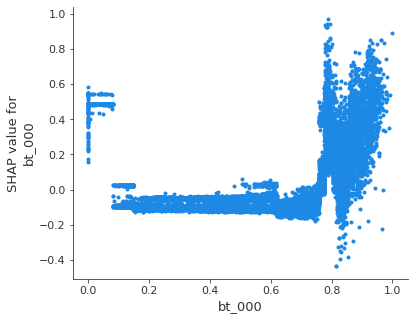

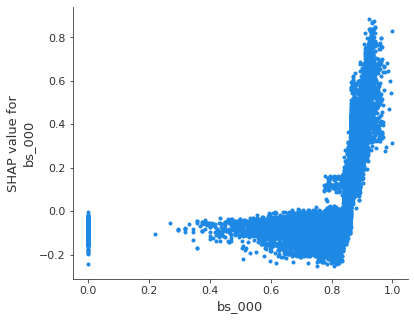

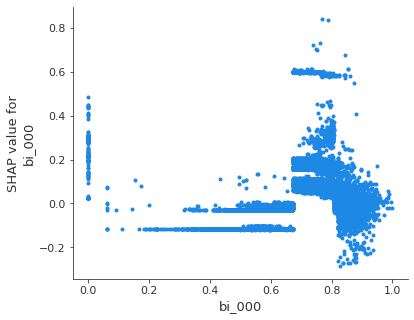

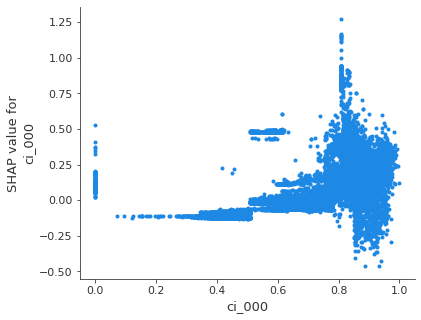

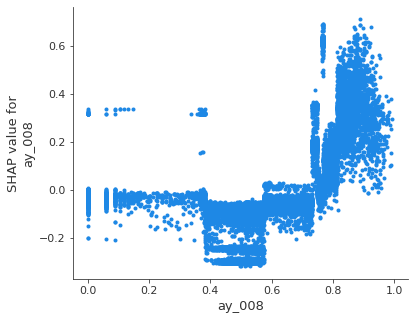

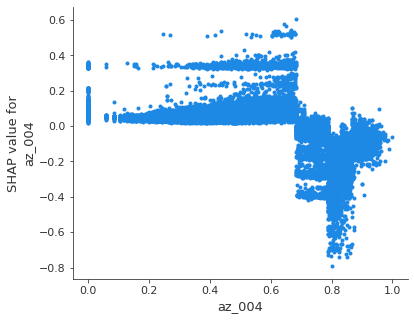

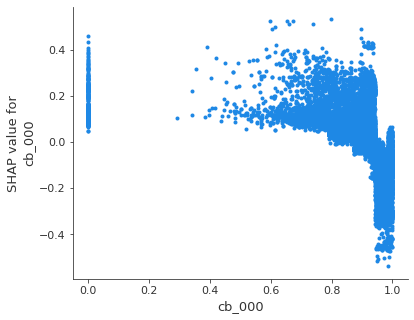

In [27]:
x_train = pd.DataFrame(x_train, columns=df_train.columns[1:])
for feat in feature_importance.head(10)['col_name']:
    shap.dependence_plot(feat, shap_values[1], x_train, interaction_index=None)

## Correlation Testing

We still need to account for the possibility of multicollinearity. Some of the features might be substitutes for one another and one way we could filter those out would be to perform pairwise correlation testing (Spearman) and then perform Hierarchical Clustering (via Single Linkage) on the correlation matrix. This is done to check which of the features have correlation scores that are close together. **The idea here is that if 2 features have very similar correlation scores across different features, then it is likely that they are substitute variables.**

A dendogram was made to visualize the cost of grouping together the different features. The lower the cost of clustering the points (i.e. distance), the more likely it is that the datapoints are substitute variables.

In [64]:
relevant_features = feature_importance[feature_importance['feature_importance_vals']>0.01].reset_index(drop=True)
df_corr = x[relevant_features['col_name']].corr('spearman')
df_corr.head()

,aa_000,ck_000,ai_000,bt_000,bs_000,bi_000,ci_000,ay_008,az_004,cb_000,...,bc_000,cn_000,dy_000,cn_007,cn_003,am_0,dx_000,cp_000,dv_000,ay_007
aa_000,1.000000,0.903377,0.292126,0.998996,0.540136,0.877925,0.976071,0.641555,0.780830,0.630570,...,0.398605,0.119459,-0.123934,0.831054,0.690669,0.134008,-0.048063,0.245665,0.539688,0.836191
ck_000,0.903377,1.000000,0.336848,0.904370,0.589632,0.880213,0.937360,0.624937,0.761188,0.636031,...,0.379736,0.135547,-0.089432,0.847858,0.655548,0.160634,-0.019829,0.285121,0.525863,0.797430
ai_000,0.292126,0.336848,1.000000,0.292285,0.250845,0.333325,0.311356,0.152016,0.284131,0.184184,...,0.077298,0.108439,-0.044937,0.294623,0.195084,0.068971,-0.028636,0.059477,0.133720,0.279624
bt_000,0.998996,0.904370,0.292285,1.000000,0.541149,0.878906,0.977056,0.641286,0.780802,0.631578,...,0.399285,0.117988,-0.123440,0.830749,0.690439,0.134461,-0.047613,0.246531,0.540633,0.835908
bs_000,0.540136,0.589632,0.250845,0.541149,1.000000,0.661196,0.553734,0.404542,0.489196,0.916482,...,0.336689,0.077800,-0.035909,0.527264,0.439993,0.127729,0.008886,0.214088,0.361234,0.504869


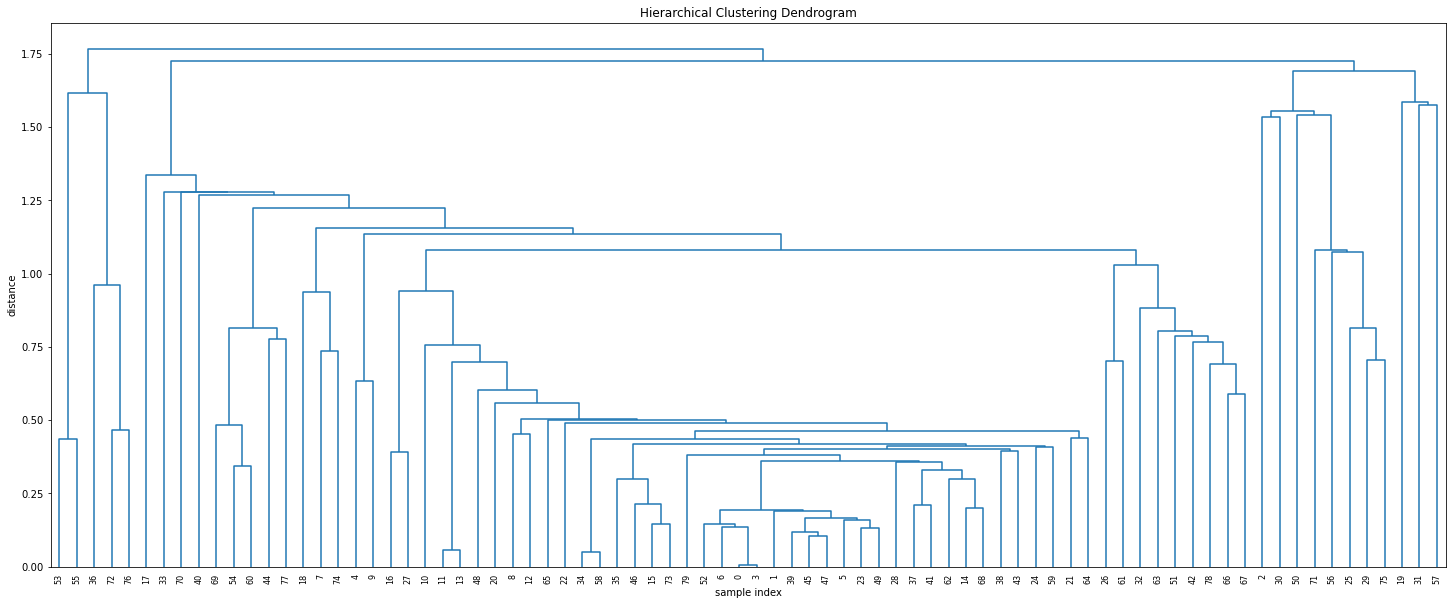

In [52]:
Z = hac.linkage(df_corr, 'single')
fig, ax = plt.subplots(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
groups = hac.dendrogram(Z,
                        leaf_rotation=90.,  # rotates the x axis labels
                        leaf_font_size=8., # font size for the x axis labels
                        color_threshold=0)

## Clustering

We will cluster the correlation matrix using different thresholds. For each cluster in each threshold, we will select the most important feature based on the SHAP score. These will serve as the selected features for the modelling.

In [66]:
feats_per_t = []
for t in np.linspace(0,1.5,20):
    clusters = hac.fcluster(Z,t, criterion='distance')
    df_tmp = relevant_features.join(pd.Series(clusters, name='cluster'))
    feats_per_t.append((t,df_tmp.groupby('cluster').max()['col_name'].values))

df_feats_per_t = pd.DataFrame(feats_per_t, columns=['threshold', 'selected_features'])
df_feats_per_t['no_feats'] = df_feats_per_t['selected_features'].apply(lambda x:len(x))
df_feats_per_t

,threshold,selected_features,no_feats
0,0.000000,"[cj_000, di_000, dy_000, dx_000, dr_000, ce_00...",80
1,0.078947,"[cj_000, di_000, dy_000, dx_000, dr_000, ce_00...",77
2,0.157895,"[cj_000, di_000, dy_000, dx_000, dr_000, ce_00...",71
3,0.236842,"[cj_000, di_000, dy_000, dx_000, dr_000, ce_00...",64
4,0.315789,"[cj_000, di_000, dy_000, dx_000, dr_000, ce_00...",62
5,0.394737,"[cj_000, di_000, dy_000, dx_000, dr_000, ce_00...",56
6,0.473684,"[di_000, dy_000, dr_000, ce_000, ax_000, ac_00...",45
7,0.552632,"[di_000, dy_000, dr_000, ce_000, ac_000, cp_00...",41
8,0.631579,"[di_000, dy_000, dr_000, ce_000, ac_000, cp_00...",38
9,0.710526,"[di_000, dy_000, dr_000, ce_000, ac_000, cp_00...",33


## Modelling Using Less Features

Using less features for the model decreases model complexity therefore making it more interpretable whilst making it easier to compute. In addition, this can actually result in an increase in performance. Different combinations of features will be tested, but the best performing combination of features consisted of the `71` features selected at a hierarchical clustering threshold of `0.157895` (see previous section).

In [251]:
selected_feats = df_feats_per_t.loc[2]['selected_features']

param_grid = {'num_leaves': [45,50,55],
              'min_data_in_leaf': [125,150,175],
              'lambda_l1': [0.00001,0.0001],
              'lambda_l2': [10,50],
              'bagging_fraction':[0.75],
              'bagging_freq':[2], 'max_depth':[6],
              'pos_bagging_fraction':[0.15],
              'neg_bagging_fraction':[0.75],
              'objective':['binary'],'path_smooth':[2],
              'min_gain_to_split':[0.25,0.3],
              'learning_rate':[0.1],
              'num_boost_round':[1500],
              'nfold':[5], 'is_unbalance':[True],
              'early_stopping_rounds':[10]}

cv_results = estimate_hyperparameters(param_grid, x[selected_feats], y)
# cv_results = estimate_hyperparameters(param_grid, x_sm, y_sm)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398257 + 0.00144077
[50]	cv_agg's binary_logloss: 0.0316708 + 0.0015061
[75]	cv_agg's binary_logloss: 0.0281532 + 0.00161835
[100]	cv_agg's binary_logloss: 0.026281 + 0.00151006
[125]	cv_agg's binary_logloss: 0.0250461 + 0.00229289
[150]	cv_agg's binary_logloss: 0.0242852 + 0.00216448
[175]	cv_agg's binary_logloss: 0.0238183 + 0.00212023
[200]	cv_agg's binary_logloss: 0.0232282 + 0.00216379
[225]	cv_agg's binary_logloss: 0.0228062 + 0.00256536
[250]	cv_agg's binary_logloss: 0.0226148 + 0.0024668
0.022602871998860078
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398257 + 0.00144077
[50]	cv_agg's binary_logloss: 0.0316708 + 0.0015061
[75]	cv_agg's binary_logloss: 0.0281532 + 0.00161835
[100]	cv_agg's binary_logloss: 0.026281 + 0.00151006
[125]	cv_agg's binary_logloss: 0.0250461 + 0.00229289
[150]	cv_agg's binary_logloss: 0.0242852 + 0.00216448
[175]	cv_agg's binary_logloss: 0.0238183 + 0.00212023
[200]	cv_agg's binary_logloss: 0.0232282 + 0.00216379
[225]	cv_agg's binary_logloss: 0.0228062 + 0.00256536
[250]	cv_agg's binary_logloss: 0.0226148 + 0.0024668
0.022602871998860078
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398257 + 0.00144077
[50]	cv_agg's binary_logloss: 0.0316708 + 0.0015061
[75]	cv_agg's binary_logloss: 0.0281532 + 0.00161835
[100]	cv_agg's binary_logloss: 0.026281 + 0.00151006
[125]	cv_agg's binary_logloss: 0.0250461 + 0.00229289
[150]	cv_agg's binary_logloss: 0.0242852 + 0.00216448
[175]	cv_agg's binary_logloss: 0.0238183 + 0.00212023
[200]	cv_agg's binary_logloss: 0.0232282 + 0.00216379
[225]	cv_agg's binary_logloss: 0.0228062 + 0.00256536
[250]	cv_agg's binary_logloss: 0.0226148 + 0.0024668
0.022602871998860078
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398103 + 0.00142763
[50]	cv_agg's binary_logloss: 0.0316056 + 0.00127191
[75]	cv_agg's binary_logloss: 0.0279698 + 0.00164531
[100]	cv_agg's binary_logloss: 0.0263082 + 0.00146566
[125]	cv_agg's binary_logloss: 0.0252492 + 0.00187808
[150]	cv_agg's binary_logloss: 0.0246454 + 0.0018995
[175]	cv_agg's binary_logloss: 0.024122 + 0.00145925
[200]	cv_agg's binary_logloss: 0.023669 + 0.00162807
[225]	cv_agg's binary_logloss: 0.0233716 + 0.00193881
0.023364484082128566
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398103 + 0.00142763
[50]	cv_agg's binary_logloss: 0.0316056 + 0.00127191
[75]	cv_agg's binary_logloss: 0.0279698 + 0.00164531
[100]	cv_agg's binary_logloss: 0.0263082 + 0.00146566
[125]	cv_agg's binary_logloss: 0.0252492 + 0.00187808
[150]	cv_agg's binary_logloss: 0.0246454 + 0.0018995
[175]	cv_agg's binary_logloss: 0.024122 + 0.00145925
[200]	cv_agg's binary_logloss: 0.023669 + 0.00162807
[225]	cv_agg's binary_logloss: 0.0233716 + 0.00193881
0.023364484082128566
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398103 + 0.00142763
[50]	cv_agg's binary_logloss: 0.0316056 + 0.00127191
[75]	cv_agg's binary_logloss: 0.0279698 + 0.00164531
[100]	cv_agg's binary_logloss: 0.0263082 + 0.00146566
[125]	cv_agg's binary_logloss: 0.0252492 + 0.00187808
[150]	cv_agg's binary_logloss: 0.0246454 + 0.0018995
[175]	cv_agg's binary_logloss: 0.024122 + 0.00145925
[200]	cv_agg's binary_logloss: 0.023669 + 0.00162807
[225]	cv_agg's binary_logloss: 0.0233716 + 0.00193881
0.023364484082128566
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0332727 + 0.00119913
[75]	cv_agg's binary_logloss: 0.0294782 + 0.00169506
[100]	cv_agg's binary_logloss: 0.0274057 + 0.0014901
[125]	cv_agg's binary_logloss: 0.0257552 + 0.00167605
[150]	cv_agg's binary_logloss: 0.0246926 + 0.00168599
[175]	cv_agg's binary_logloss: 0.023899 + 0.0015887
[200]	cv_agg's binary_logloss: 0.0234468 + 0.00164294
[225]	cv_agg's binary_logloss: 0.0228554 + 0.00195934
[250]	cv_agg's binary_logloss: 0.0225618 + 0.00204014
[275]	cv_agg's binary_logloss: 0.0223079 + 0.00216841
0.0219847720087607
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0332727 + 0.00119913
[75]	cv_agg's binary_logloss: 0.0294782 + 0.00169506
[100]	cv_agg's binary_logloss: 0.0274057 + 0.0014901
[125]	cv_agg's binary_logloss: 0.0257552 + 0.00167605
[150]	cv_agg's binary_logloss: 0.0246926 + 0.00168599
[175]	cv_agg's binary_logloss: 0.023899 + 0.0015887
[200]	cv_agg's binary_logloss: 0.0234468 + 0.00164294
[225]	cv_agg's binary_logloss: 0.0228554 + 0.00195934
[250]	cv_agg's binary_logloss: 0.0225618 + 0.00204014
[275]	cv_agg's binary_logloss: 0.0223079 + 0.00216841
0.0219847720087607
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0332727 + 0.00119913
[75]	cv_agg's binary_logloss: 0.0294782 + 0.00169506
[100]	cv_agg's binary_logloss: 0.0274057 + 0.0014901
[125]	cv_agg's binary_logloss: 0.0257552 + 0.00167605
[150]	cv_agg's binary_logloss: 0.0246926 + 0.00168599
[175]	cv_agg's binary_logloss: 0.023899 + 0.0015887
[200]	cv_agg's binary_logloss: 0.0234468 + 0.00164294
[225]	cv_agg's binary_logloss: 0.0228554 + 0.00195934
[250]	cv_agg's binary_logloss: 0.0225618 + 0.00204014
[275]	cv_agg's binary_logloss: 0.0223079 + 0.00216841
0.0219847720087607
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0333005 + 0.00123044
[75]	cv_agg's binary_logloss: 0.0291903 + 0.00147051
[100]	cv_agg's binary_logloss: 0.027389 + 0.00139437
[125]	cv_agg's binary_logloss: 0.025753 + 0.00153828
[150]	cv_agg's binary_logloss: 0.0248618 + 0.00163816
[175]	cv_agg's binary_logloss: 0.023842 + 0.00126628
[200]	cv_agg's binary_logloss: 0.0232052 + 0.00132057
[225]	cv_agg's binary_logloss: 0.0228426 + 0.00165788
0.02277463333480194
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0333005 + 0.00123044
[75]	cv_agg's binary_logloss: 0.0291903 + 0.00147051
[100]	cv_agg's binary_logloss: 0.027389 + 0.00139437
[125]	cv_agg's binary_logloss: 0.025753 + 0.00153828
[150]	cv_agg's binary_logloss: 0.0248618 + 0.00163816
[175]	cv_agg's binary_logloss: 0.023842 + 0.00126628
[200]	cv_agg's binary_logloss: 0.0232052 + 0.00132057
[225]	cv_agg's binary_logloss: 0.0228426 + 0.00165788
0.02277463333480194
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0333005 + 0.00123044
[75]	cv_agg's binary_logloss: 0.0291903 + 0.00147051
[100]	cv_agg's binary_logloss: 0.027389 + 0.00139437
[125]	cv_agg's binary_logloss: 0.025753 + 0.00153828
[150]	cv_agg's binary_logloss: 0.0248618 + 0.00163816
[175]	cv_agg's binary_logloss: 0.023842 + 0.00126628
[200]	cv_agg's binary_logloss: 0.0232052 + 0.00132057
[225]	cv_agg's binary_logloss: 0.0228426 + 0.00165788
0.02277463333480194
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330374 + 0.00190994
[75]	cv_agg's binary_logloss: 0.0295938 + 0.00175938
[100]	cv_agg's binary_logloss: 0.0276177 + 0.00144196
[125]	cv_agg's binary_logloss: 0.0257403 + 0.00145607
[150]	cv_agg's binary_logloss: 0.0248539 + 0.0015736
[175]	cv_agg's binary_logloss: 0.0241324 + 0.00125523
[200]	cv_agg's binary_logloss: 0.0234463 + 0.00167748
[225]	cv_agg's binary_logloss: 0.023034 + 0.00176733
0.023027831596660005
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330374 + 0.00190994
[75]	cv_agg's binary_logloss: 0.0295938 + 0.00175938
[100]	cv_agg's binary_logloss: 0.0276177 + 0.00144196
[125]	cv_agg's binary_logloss: 0.0257403 + 0.00145607
[150]	cv_agg's binary_logloss: 0.0248539 + 0.0015736
[175]	cv_agg's binary_logloss: 0.0241324 + 0.00125523
[200]	cv_agg's binary_logloss: 0.0234463 + 0.00167748
[225]	cv_agg's binary_logloss: 0.023034 + 0.00176733
0.023027831596660005
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330374 + 0.00190994
[75]	cv_agg's binary_logloss: 0.0295938 + 0.00175938
[100]	cv_agg's binary_logloss: 0.0276177 + 0.00144196
[125]	cv_agg's binary_logloss: 0.0257403 + 0.00145607
[150]	cv_agg's binary_logloss: 0.0248539 + 0.0015736
[175]	cv_agg's binary_logloss: 0.0241324 + 0.00125523
[200]	cv_agg's binary_logloss: 0.0234463 + 0.00167748
[225]	cv_agg's binary_logloss: 0.023034 + 0.00176733
0.023027831596660005
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330403 + 0.00190514
[75]	cv_agg's binary_logloss: 0.0296252 + 0.00170909
[100]	cv_agg's binary_logloss: 0.0277525 + 0.00179448
[125]	cv_agg's binary_logloss: 0.0260741 + 0.00236022
[150]	cv_agg's binary_logloss: 0.0252105 + 0.00261092
[175]	cv_agg's binary_logloss: 0.0245912 + 0.00213443
[200]	cv_agg's binary_logloss: 0.0239499 + 0.00227244
[225]	cv_agg's binary_logloss: 0.0234508 + 0.00259445
0.023399381459993884
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330403 + 0.00190514
[75]	cv_agg's binary_logloss: 0.0296252 + 0.00170909
[100]	cv_agg's binary_logloss: 0.0277525 + 0.00179448
[125]	cv_agg's binary_logloss: 0.0260741 + 0.00236022
[150]	cv_agg's binary_logloss: 0.0252105 + 0.00261092
[175]	cv_agg's binary_logloss: 0.0245912 + 0.00213443
[200]	cv_agg's binary_logloss: 0.0239499 + 0.00227244
[225]	cv_agg's binary_logloss: 0.0234508 + 0.00259445
0.023399381459993884
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330403 + 0.00190514
[75]	cv_agg's binary_logloss: 0.0296252 + 0.00170909
[100]	cv_agg's binary_logloss: 0.0277525 + 0.00179448
[125]	cv_agg's binary_logloss: 0.0260741 + 0.00236022
[150]	cv_agg's binary_logloss: 0.0252105 + 0.00261092
[175]	cv_agg's binary_logloss: 0.0245912 + 0.00213443
[200]	cv_agg's binary_logloss: 0.0239499 + 0.00227244
[225]	cv_agg's binary_logloss: 0.0234508 + 0.00259445
0.023399381459993884
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0428907 + 0.00179121
[50]	cv_agg's binary_logloss: 0.0367853 + 0.00149273
[75]	cv_agg's binary_logloss: 0.0327249 + 0.00140179
[100]	cv_agg's binary_logloss: 0.0302595 + 0.00158331
[125]	cv_agg's binary_logloss: 0.0286228 + 0.0015712
[150]	cv_agg's binary_logloss: 0.0274054 + 0.00166844
[175]	cv_agg's binary_logloss: 0.0264188 + 0.00117952
[200]	cv_agg's binary_logloss: 0.0252927 + 0.00122273
[225]	cv_agg's binary_logloss: 0.0245696 + 0.0017312
[250]	cv_agg's binary_logloss: 0.0238298 + 0.00166202
[275]	cv_agg's binary_logloss: 0.0236031 + 0.00170416
0.02342373675280542
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0428907 + 0.00179121
[50]	cv_agg's binary_logloss: 0.0367853 + 0.00149273
[75]	cv_agg's binary_logloss: 0.0327249 + 0.00140179
[100]	cv_agg's binary_logloss: 0.0302595 + 0.00158331
[125]	cv_agg's binary_logloss: 0.0286228 + 0.0015712
[150]	cv_agg's binary_logloss: 0.0274054 + 0.00166844
[175]	cv_agg's binary_logloss: 0.0264188 + 0.00117952
[200]	cv_agg's binary_logloss: 0.0252927 + 0.00122273
[225]	cv_agg's binary_logloss: 0.0245696 + 0.0017312
[250]	cv_agg's binary_logloss: 0.0238298 + 0.00166202
[275]	cv_agg's binary_logloss: 0.0236031 + 0.00170416
0.02342373675280542
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0428907 + 0.00179121
[50]	cv_agg's binary_logloss: 0.0367853 + 0.00149273
[75]	cv_agg's binary_logloss: 0.0327249 + 0.00140179
[100]	cv_agg's binary_logloss: 0.0302595 + 0.00158331
[125]	cv_agg's binary_logloss: 0.0286228 + 0.0015712
[150]	cv_agg's binary_logloss: 0.0274054 + 0.00166844
[175]	cv_agg's binary_logloss: 0.0264188 + 0.00117952
[200]	cv_agg's binary_logloss: 0.0252927 + 0.00122273
[225]	cv_agg's binary_logloss: 0.0245696 + 0.0017312
[250]	cv_agg's binary_logloss: 0.0238298 + 0.00166202
[275]	cv_agg's binary_logloss: 0.0236031 + 0.00170416
0.02342373675280542
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430138 + 0.00162667
[50]	cv_agg's binary_logloss: 0.0367557 + 0.00153799
[75]	cv_agg's binary_logloss: 0.032674 + 0.00152833
[100]	cv_agg's binary_logloss: 0.0302806 + 0.00179943
[125]	cv_agg's binary_logloss: 0.0286696 + 0.00157288
[150]	cv_agg's binary_logloss: 0.0272092 + 0.00168171
[175]	cv_agg's binary_logloss: 0.0262628 + 0.00182292
[200]	cv_agg's binary_logloss: 0.025413 + 0.00183603
[225]	cv_agg's binary_logloss: 0.0247551 + 0.00224789
[250]	cv_agg's binary_logloss: 0.0243092 + 0.00217148
[275]	cv_agg's binary_logloss: 0.023923 + 0.0021259
[300]	cv_agg's binary_logloss: 0.0232664 + 0.0021424
0.0232663650666897
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smoo

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430138 + 0.00162667
[50]	cv_agg's binary_logloss: 0.0367557 + 0.00153799
[75]	cv_agg's binary_logloss: 0.032674 + 0.00152833
[100]	cv_agg's binary_logloss: 0.0302806 + 0.00179943
[125]	cv_agg's binary_logloss: 0.0286696 + 0.00157288
[150]	cv_agg's binary_logloss: 0.0272092 + 0.00168171
[175]	cv_agg's binary_logloss: 0.0262628 + 0.00182292
[200]	cv_agg's binary_logloss: 0.025413 + 0.00183603
[225]	cv_agg's binary_logloss: 0.0247551 + 0.00224789
[250]	cv_agg's binary_logloss: 0.0243092 + 0.00217148
[275]	cv_agg's binary_logloss: 0.023923 + 0.0021259
[300]	cv_agg's binary_logloss: 0.0232664 + 0.0021424
0.0232663650666897
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smoo

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430138 + 0.00162667
[50]	cv_agg's binary_logloss: 0.0367557 + 0.00153799
[75]	cv_agg's binary_logloss: 0.032674 + 0.00152833
[100]	cv_agg's binary_logloss: 0.0302806 + 0.00179943
[125]	cv_agg's binary_logloss: 0.0286696 + 0.00157288
[150]	cv_agg's binary_logloss: 0.0272092 + 0.00168171
[175]	cv_agg's binary_logloss: 0.0262628 + 0.00182292
[200]	cv_agg's binary_logloss: 0.025413 + 0.00183603
[225]	cv_agg's binary_logloss: 0.0247551 + 0.00224789
[250]	cv_agg's binary_logloss: 0.0243092 + 0.00217148
[275]	cv_agg's binary_logloss: 0.023923 + 0.0021259
[300]	cv_agg's binary_logloss: 0.0232664 + 0.0021424
0.0232663650666897
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smoo

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0435877 + 0.00167967
[50]	cv_agg's binary_logloss: 0.0375319 + 0.00151423
[75]	cv_agg's binary_logloss: 0.0333353 + 0.00201515
[100]	cv_agg's binary_logloss: 0.0308438 + 0.00211741
[125]	cv_agg's binary_logloss: 0.0291809 + 0.0017848
[150]	cv_agg's binary_logloss: 0.0279165 + 0.00193696
[175]	cv_agg's binary_logloss: 0.0270629 + 0.00152612
0.02698889996633049
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0435877 + 0.00167967
[50]	cv_agg's binary_logloss: 0.0375319 + 0.00151423
[75]	cv_agg's binary_logloss: 0.0333353 + 0.00201515
[100]	cv_agg's binary_logloss: 0.0308438 + 0.00211741
[125]	cv_agg's binary_logloss: 0.0291809 + 0.0017848
[150]	cv_agg's binary_logloss: 0.0279165 + 0.00193696
[175]	cv_agg's binary_logloss: 0.0270629 + 0.00152612
0.02698889996633049
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0435877 + 0.00167967
[50]	cv_agg's binary_logloss: 0.0375319 + 0.00151423
[75]	cv_agg's binary_logloss: 0.0333353 + 0.00201515
[100]	cv_agg's binary_logloss: 0.0308438 + 0.00211741
[125]	cv_agg's binary_logloss: 0.0291809 + 0.0017848
[150]	cv_agg's binary_logloss: 0.0279165 + 0.00193696
[175]	cv_agg's binary_logloss: 0.0270629 + 0.00152612
0.02698889996633049
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0436312 + 0.00168596
[50]	cv_agg's binary_logloss: 0.0377421 + 0.00163939
[75]	cv_agg's binary_logloss: 0.0334335 + 0.00202787
[100]	cv_agg's binary_logloss: 0.0307336 + 0.00209806
[125]	cv_agg's binary_logloss: 0.0290905 + 0.0017722
[150]	cv_agg's binary_logloss: 0.0278439 + 0.00190317
[175]	cv_agg's binary_logloss: 0.0269572 + 0.00173061
[200]	cv_agg's binary_logloss: 0.0260086 + 0.0017385
[225]	cv_agg's binary_logloss: 0.0252811 + 0.00207274
[250]	cv_agg's binary_logloss: 0.0245858 + 0.00211129
[275]	cv_agg's binary_logloss: 0.0242944 + 0.00203507
0.024193822020476676
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0436312 + 0.00168596
[50]	cv_agg's binary_logloss: 0.0377421 + 0.00163939
[75]	cv_agg's binary_logloss: 0.0334335 + 0.00202787
[100]	cv_agg's binary_logloss: 0.0307336 + 0.00209806
[125]	cv_agg's binary_logloss: 0.0290905 + 0.0017722
[150]	cv_agg's binary_logloss: 0.0278439 + 0.00190317
[175]	cv_agg's binary_logloss: 0.0269572 + 0.00173061
[200]	cv_agg's binary_logloss: 0.0260086 + 0.0017385
[225]	cv_agg's binary_logloss: 0.0252811 + 0.00207274
[250]	cv_agg's binary_logloss: 0.0245858 + 0.00211129
[275]	cv_agg's binary_logloss: 0.0242944 + 0.00203507
0.024193822020476676
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0436312 + 0.00168596
[50]	cv_agg's binary_logloss: 0.0377421 + 0.00163939
[75]	cv_agg's binary_logloss: 0.0334335 + 0.00202787
[100]	cv_agg's binary_logloss: 0.0307336 + 0.00209806
[125]	cv_agg's binary_logloss: 0.0290905 + 0.0017722
[150]	cv_agg's binary_logloss: 0.0278439 + 0.00190317
[175]	cv_agg's binary_logloss: 0.0269572 + 0.00173061
[200]	cv_agg's binary_logloss: 0.0260086 + 0.0017385
[225]	cv_agg's binary_logloss: 0.0252811 + 0.00207274
[250]	cv_agg's binary_logloss: 0.0245858 + 0.00211129
[275]	cv_agg's binary_logloss: 0.0242944 + 0.00203507
0.024193822020476676
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0443799 + 0.000770492
[50]	cv_agg's binary_logloss: 0.0385002 + 0.000837023
[75]	cv_agg's binary_logloss: 0.0342344 + 0.00142151
[100]	cv_agg's binary_logloss: 0.0315326 + 0.00155116
[125]	cv_agg's binary_logloss: 0.0296846 + 0.00143932
[150]	cv_agg's binary_logloss: 0.0286368 + 0.00139899
[175]	cv_agg's binary_logloss: 0.0275919 + 0.00100704
[200]	cv_agg's binary_logloss: 0.0267163 + 0.00115056
[225]	cv_agg's binary_logloss: 0.0257326 + 0.00165658
[250]	cv_agg's binary_logloss: 0.0250795 + 0.00169313
[275]	cv_agg's binary_logloss: 0.0248972 + 0.00157061
0.024774636150640537
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0443799 + 0.000770492
[50]	cv_agg's binary_logloss: 0.0385002 + 0.000837023
[75]	cv_agg's binary_logloss: 0.0342344 + 0.00142151
[100]	cv_agg's binary_logloss: 0.0315326 + 0.00155116
[125]	cv_agg's binary_logloss: 0.0296846 + 0.00143932
[150]	cv_agg's binary_logloss: 0.0286368 + 0.00139899
[175]	cv_agg's binary_logloss: 0.0275919 + 0.00100704
[200]	cv_agg's binary_logloss: 0.0267163 + 0.00115056
[225]	cv_agg's binary_logloss: 0.0257326 + 0.00165658
[250]	cv_agg's binary_logloss: 0.0250795 + 0.00169313
[275]	cv_agg's binary_logloss: 0.0248972 + 0.00157061
0.024774636150640537
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0443799 + 0.000770492
[50]	cv_agg's binary_logloss: 0.0385002 + 0.000837023
[75]	cv_agg's binary_logloss: 0.0342344 + 0.00142151
[100]	cv_agg's binary_logloss: 0.0315326 + 0.00155116
[125]	cv_agg's binary_logloss: 0.0296846 + 0.00143932
[150]	cv_agg's binary_logloss: 0.0286368 + 0.00139899
[175]	cv_agg's binary_logloss: 0.0275919 + 0.00100704
[200]	cv_agg's binary_logloss: 0.0267163 + 0.00115056
[225]	cv_agg's binary_logloss: 0.0257326 + 0.00165658
[250]	cv_agg's binary_logloss: 0.0250795 + 0.00169313
[275]	cv_agg's binary_logloss: 0.0248972 + 0.00157061
0.024774636150640537
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.044106 + 0.00123918
[50]	cv_agg's binary_logloss: 0.0383686 + 0.0010216
[75]	cv_agg's binary_logloss: 0.0341276 + 0.00142082
[100]	cv_agg's binary_logloss: 0.0316075 + 0.00159615
[125]	cv_agg's binary_logloss: 0.02971 + 0.00106616
[150]	cv_agg's binary_logloss: 0.0285685 + 0.001233
[175]	cv_agg's binary_logloss: 0.0276455 + 0.000985116
[200]	cv_agg's binary_logloss: 0.0266481 + 0.000926174
[225]	cv_agg's binary_logloss: 0.0257241 + 0.00105031
[250]	cv_agg's binary_logloss: 0.0249028 + 0.00104182
[275]	cv_agg's binary_logloss: 0.0245688 + 0.000986154
[300]	cv_agg's binary_logloss: 0.0238095 + 0.000987574
0.023809528597707453
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.044106 + 0.00123918
[50]	cv_agg's binary_logloss: 0.0383686 + 0.0010216
[75]	cv_agg's binary_logloss: 0.0341276 + 0.00142082
[100]	cv_agg's binary_logloss: 0.0316075 + 0.00159615
[125]	cv_agg's binary_logloss: 0.02971 + 0.00106616
[150]	cv_agg's binary_logloss: 0.0285685 + 0.001233
[175]	cv_agg's binary_logloss: 0.0276455 + 0.000985116
[200]	cv_agg's binary_logloss: 0.0266481 + 0.000926174
[225]	cv_agg's binary_logloss: 0.0257241 + 0.00105031
[250]	cv_agg's binary_logloss: 0.0249028 + 0.00104182
[275]	cv_agg's binary_logloss: 0.0245688 + 0.000986154
[300]	cv_agg's binary_logloss: 0.0238095 + 0.000987574
0.023809528597707453
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.044106 + 0.00123918
[50]	cv_agg's binary_logloss: 0.0383686 + 0.0010216
[75]	cv_agg's binary_logloss: 0.0341276 + 0.00142082
[100]	cv_agg's binary_logloss: 0.0316075 + 0.00159615
[125]	cv_agg's binary_logloss: 0.02971 + 0.00106616
[150]	cv_agg's binary_logloss: 0.0285685 + 0.001233
[175]	cv_agg's binary_logloss: 0.0276455 + 0.000985116
[200]	cv_agg's binary_logloss: 0.0266481 + 0.000926174
[225]	cv_agg's binary_logloss: 0.0257241 + 0.00105031
[250]	cv_agg's binary_logloss: 0.0249028 + 0.00104182
[275]	cv_agg's binary_logloss: 0.0245688 + 0.000986154
[300]	cv_agg's binary_logloss: 0.0238095 + 0.000987574
0.023809528597707453
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 1e-05, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398257 + 0.00144077
[50]	cv_agg's binary_logloss: 0.0316624 + 0.00151501
[75]	cv_agg's binary_logloss: 0.0279367 + 0.00190241
[100]	cv_agg's binary_logloss: 0.0260778 + 0.00172732
[125]	cv_agg's binary_logloss: 0.0250563 + 0.00228538
[150]	cv_agg's binary_logloss: 0.0242163 + 0.00219139
[175]	cv_agg's binary_logloss: 0.0237593 + 0.00214539
[200]	cv_agg's binary_logloss: 0.0231608 + 0.00219854
[225]	cv_agg's binary_logloss: 0.0228558 + 0.00254909
[250]	cv_agg's binary_logloss: 0.022636 + 0.00246301
0.02259232894330796
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398257 + 0.00144077
[50]	cv_agg's binary_logloss: 0.0316624 + 0.00151501
[75]	cv_agg's binary_logloss: 0.0279367 + 0.00190241
[100]	cv_agg's binary_logloss: 0.0260778 + 0.00172732
[125]	cv_agg's binary_logloss: 0.0250563 + 0.00228538
[150]	cv_agg's binary_logloss: 0.0242163 + 0.00219139
[175]	cv_agg's binary_logloss: 0.0237593 + 0.00214539
[200]	cv_agg's binary_logloss: 0.0231608 + 0.00219854
[225]	cv_agg's binary_logloss: 0.0228558 + 0.00254909
[250]	cv_agg's binary_logloss: 0.022636 + 0.00246301
0.02259232894330796
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398257 + 0.00144077
[50]	cv_agg's binary_logloss: 0.0316624 + 0.00151501
[75]	cv_agg's binary_logloss: 0.0279367 + 0.00190241
[100]	cv_agg's binary_logloss: 0.0260778 + 0.00172732
[125]	cv_agg's binary_logloss: 0.0250563 + 0.00228538
[150]	cv_agg's binary_logloss: 0.0242163 + 0.00219139
[175]	cv_agg's binary_logloss: 0.0237593 + 0.00214539
[200]	cv_agg's binary_logloss: 0.0231608 + 0.00219854
[225]	cv_agg's binary_logloss: 0.0228558 + 0.00254909
[250]	cv_agg's binary_logloss: 0.022636 + 0.00246301
0.02259232894330796
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398103 + 0.00142763
[50]	cv_agg's binary_logloss: 0.0316056 + 0.00127191
[75]	cv_agg's binary_logloss: 0.0279698 + 0.0016453
[100]	cv_agg's binary_logloss: 0.0263082 + 0.00146566
[125]	cv_agg's binary_logloss: 0.0252492 + 0.00187808
[150]	cv_agg's binary_logloss: 0.0246454 + 0.0018995
[175]	cv_agg's binary_logloss: 0.024122 + 0.00145924
[200]	cv_agg's binary_logloss: 0.023669 + 0.00162806
[225]	cv_agg's binary_logloss: 0.0233716 + 0.0019388
0.0233644825020084
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398103 + 0.00142763
[50]	cv_agg's binary_logloss: 0.0316056 + 0.00127191
[75]	cv_agg's binary_logloss: 0.0279698 + 0.0016453
[100]	cv_agg's binary_logloss: 0.0263082 + 0.00146566
[125]	cv_agg's binary_logloss: 0.0252492 + 0.00187808
[150]	cv_agg's binary_logloss: 0.0246454 + 0.0018995
[175]	cv_agg's binary_logloss: 0.024122 + 0.00145924
[200]	cv_agg's binary_logloss: 0.023669 + 0.00162806
[225]	cv_agg's binary_logloss: 0.0233716 + 0.0019388
0.0233644825020084
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0398103 + 0.00142763
[50]	cv_agg's binary_logloss: 0.0316056 + 0.00127191
[75]	cv_agg's binary_logloss: 0.0279698 + 0.0016453
[100]	cv_agg's binary_logloss: 0.0263082 + 0.00146566
[125]	cv_agg's binary_logloss: 0.0252492 + 0.00187808
[150]	cv_agg's binary_logloss: 0.0246454 + 0.0018995
[175]	cv_agg's binary_logloss: 0.024122 + 0.00145924
[200]	cv_agg's binary_logloss: 0.023669 + 0.00162806
[225]	cv_agg's binary_logloss: 0.0233716 + 0.0019388
0.0233644825020084
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0332727 + 0.00119913
[75]	cv_agg's binary_logloss: 0.0294782 + 0.00169506
[100]	cv_agg's binary_logloss: 0.0274057 + 0.0014901
[125]	cv_agg's binary_logloss: 0.0257552 + 0.00167605
[150]	cv_agg's binary_logloss: 0.0246926 + 0.00168599
[175]	cv_agg's binary_logloss: 0.023899 + 0.0015887
[200]	cv_agg's binary_logloss: 0.0234468 + 0.00164294
[225]	cv_agg's binary_logloss: 0.0228554 + 0.00195934
[250]	cv_agg's binary_logloss: 0.0225618 + 0.00204014
[275]	cv_agg's binary_logloss: 0.0223079 + 0.00216841
0.021984767998912393
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0332727 + 0.00119913
[75]	cv_agg's binary_logloss: 0.0294782 + 0.00169506
[100]	cv_agg's binary_logloss: 0.0274057 + 0.0014901
[125]	cv_agg's binary_logloss: 0.0257552 + 0.00167605
[150]	cv_agg's binary_logloss: 0.0246926 + 0.00168599
[175]	cv_agg's binary_logloss: 0.023899 + 0.0015887
[200]	cv_agg's binary_logloss: 0.0234468 + 0.00164294
[225]	cv_agg's binary_logloss: 0.0228554 + 0.00195934
[250]	cv_agg's binary_logloss: 0.0225618 + 0.00204014
[275]	cv_agg's binary_logloss: 0.0223079 + 0.00216841
0.021984767998912393
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0332727 + 0.00119913
[75]	cv_agg's binary_logloss: 0.0294782 + 0.00169506
[100]	cv_agg's binary_logloss: 0.0274057 + 0.0014901
[125]	cv_agg's binary_logloss: 0.0257552 + 0.00167605
[150]	cv_agg's binary_logloss: 0.0246926 + 0.00168599
[175]	cv_agg's binary_logloss: 0.023899 + 0.0015887
[200]	cv_agg's binary_logloss: 0.0234468 + 0.00164294
[225]	cv_agg's binary_logloss: 0.0228554 + 0.00195934
[250]	cv_agg's binary_logloss: 0.0225618 + 0.00204014
[275]	cv_agg's binary_logloss: 0.0223079 + 0.00216841
0.021984767998912393
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0333005 + 0.00123043
[75]	cv_agg's binary_logloss: 0.0291904 + 0.0014705
[100]	cv_agg's binary_logloss: 0.027389 + 0.00139436
[125]	cv_agg's binary_logloss: 0.025753 + 0.00153828
[150]	cv_agg's binary_logloss: 0.0248618 + 0.00163815
[175]	cv_agg's binary_logloss: 0.023842 + 0.00126627
[200]	cv_agg's binary_logloss: 0.0232052 + 0.00132057
[225]	cv_agg's binary_logloss: 0.0228426 + 0.00165787
0.022774634206506498
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0333005 + 0.00123043
[75]	cv_agg's binary_logloss: 0.0291904 + 0.0014705
[100]	cv_agg's binary_logloss: 0.027389 + 0.00139436
[125]	cv_agg's binary_logloss: 0.025753 + 0.00153828
[150]	cv_agg's binary_logloss: 0.0248618 + 0.00163815
[175]	cv_agg's binary_logloss: 0.023842 + 0.00126627
[200]	cv_agg's binary_logloss: 0.0232052 + 0.00132057
[225]	cv_agg's binary_logloss: 0.0228426 + 0.00165787
0.022774634206506498
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0411385 + 0.00172849
[50]	cv_agg's binary_logloss: 0.0333005 + 0.00123043
[75]	cv_agg's binary_logloss: 0.0291904 + 0.0014705
[100]	cv_agg's binary_logloss: 0.027389 + 0.00139436
[125]	cv_agg's binary_logloss: 0.025753 + 0.00153828
[150]	cv_agg's binary_logloss: 0.0248618 + 0.00163815
[175]	cv_agg's binary_logloss: 0.023842 + 0.00126627
[200]	cv_agg's binary_logloss: 0.0232052 + 0.00132057
[225]	cv_agg's binary_logloss: 0.0228426 + 0.00165787
0.022774634206506498
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330375 + 0.00190994
[75]	cv_agg's binary_logloss: 0.0295939 + 0.00175938
[100]	cv_agg's binary_logloss: 0.0276177 + 0.00144196
[125]	cv_agg's binary_logloss: 0.0257403 + 0.00145606
[150]	cv_agg's binary_logloss: 0.0248539 + 0.0015736
[175]	cv_agg's binary_logloss: 0.0241324 + 0.00125523
[200]	cv_agg's binary_logloss: 0.0234463 + 0.00167748
[225]	cv_agg's binary_logloss: 0.023034 + 0.00176732
0.023027832594856263
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330375 + 0.00190994
[75]	cv_agg's binary_logloss: 0.0295939 + 0.00175938
[100]	cv_agg's binary_logloss: 0.0276177 + 0.00144196
[125]	cv_agg's binary_logloss: 0.0257403 + 0.00145606
[150]	cv_agg's binary_logloss: 0.0248539 + 0.0015736
[175]	cv_agg's binary_logloss: 0.0241324 + 0.00125523
[200]	cv_agg's binary_logloss: 0.0234463 + 0.00167748
[225]	cv_agg's binary_logloss: 0.023034 + 0.00176732
0.023027832594856263
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330375 + 0.00190994
[75]	cv_agg's binary_logloss: 0.0295939 + 0.00175938
[100]	cv_agg's binary_logloss: 0.0276177 + 0.00144196
[125]	cv_agg's binary_logloss: 0.0257403 + 0.00145606
[150]	cv_agg's binary_logloss: 0.0248539 + 0.0015736
[175]	cv_agg's binary_logloss: 0.0241324 + 0.00125523
[200]	cv_agg's binary_logloss: 0.0234463 + 0.00167748
[225]	cv_agg's binary_logloss: 0.023034 + 0.00176732
0.023027832594856263
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330403 + 0.00190513
[75]	cv_agg's binary_logloss: 0.0296252 + 0.00170909
[100]	cv_agg's binary_logloss: 0.0277526 + 0.00179447
[125]	cv_agg's binary_logloss: 0.0260741 + 0.00236021
[150]	cv_agg's binary_logloss: 0.0252106 + 0.00261091
[175]	cv_agg's binary_logloss: 0.0245912 + 0.00213442
[200]	cv_agg's binary_logloss: 0.0239499 + 0.00227244
[225]	cv_agg's binary_logloss: 0.0234508 + 0.00259444
0.02339938020885387
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330403 + 0.00190513
[75]	cv_agg's binary_logloss: 0.0296252 + 0.00170909
[100]	cv_agg's binary_logloss: 0.0277526 + 0.00179447
[125]	cv_agg's binary_logloss: 0.0260741 + 0.00236021
[150]	cv_agg's binary_logloss: 0.0252106 + 0.00261091
[175]	cv_agg's binary_logloss: 0.0245912 + 0.00213442
[200]	cv_agg's binary_logloss: 0.0239499 + 0.00227244
[225]	cv_agg's binary_logloss: 0.0234508 + 0.00259444
0.02339938020885387
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0422306 + 0.00194949
[50]	cv_agg's binary_logloss: 0.0330403 + 0.00190513
[75]	cv_agg's binary_logloss: 0.0296252 + 0.00170909
[100]	cv_agg's binary_logloss: 0.0277526 + 0.00179447
[125]	cv_agg's binary_logloss: 0.0260741 + 0.00236021
[150]	cv_agg's binary_logloss: 0.0252106 + 0.00261091
[175]	cv_agg's binary_logloss: 0.0245912 + 0.00213442
[200]	cv_agg's binary_logloss: 0.0239499 + 0.00227244
[225]	cv_agg's binary_logloss: 0.0234508 + 0.00259444
0.02339938020885387
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 10, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430136 + 0.00162659
[50]	cv_agg's binary_logloss: 0.0367573 + 0.00153824
[75]	cv_agg's binary_logloss: 0.032644 + 0.00153697
[100]	cv_agg's binary_logloss: 0.0302644 + 0.00157648
[125]	cv_agg's binary_logloss: 0.0285749 + 0.00164263
[150]	cv_agg's binary_logloss: 0.0273075 + 0.00184788
[175]	cv_agg's binary_logloss: 0.026139 + 0.00170768
[200]	cv_agg's binary_logloss: 0.0251149 + 0.00156651
[225]	cv_agg's binary_logloss: 0.0244697 + 0.00191506
[250]	cv_agg's binary_logloss: 0.0237178 + 0.00185991
[275]	cv_agg's binary_logloss: 0.0234538 + 0.00196636
0.023299934945656568
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430136 + 0.00162659
[50]	cv_agg's binary_logloss: 0.0367573 + 0.00153824
[75]	cv_agg's binary_logloss: 0.032644 + 0.00153697
[100]	cv_agg's binary_logloss: 0.0302644 + 0.00157648
[125]	cv_agg's binary_logloss: 0.0285749 + 0.00164263
[150]	cv_agg's binary_logloss: 0.0273075 + 0.00184788
[175]	cv_agg's binary_logloss: 0.026139 + 0.00170768
[200]	cv_agg's binary_logloss: 0.0251149 + 0.00156651
[225]	cv_agg's binary_logloss: 0.0244697 + 0.00191506
[250]	cv_agg's binary_logloss: 0.0237178 + 0.00185991
[275]	cv_agg's binary_logloss: 0.0234538 + 0.00196636
0.023299934945656568
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430136 + 0.00162659
[50]	cv_agg's binary_logloss: 0.0367573 + 0.00153824
[75]	cv_agg's binary_logloss: 0.032644 + 0.00153697
[100]	cv_agg's binary_logloss: 0.0302644 + 0.00157648
[125]	cv_agg's binary_logloss: 0.0285749 + 0.00164263
[150]	cv_agg's binary_logloss: 0.0273075 + 0.00184788
[175]	cv_agg's binary_logloss: 0.026139 + 0.00170768
[200]	cv_agg's binary_logloss: 0.0251149 + 0.00156651
[225]	cv_agg's binary_logloss: 0.0244697 + 0.00191506
[250]	cv_agg's binary_logloss: 0.0237178 + 0.00185991
[275]	cv_agg's binary_logloss: 0.0234538 + 0.00196636
0.023299934945656568
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430138 + 0.00162667
[50]	cv_agg's binary_logloss: 0.0367557 + 0.00153799
[75]	cv_agg's binary_logloss: 0.032674 + 0.00152833
[100]	cv_agg's binary_logloss: 0.0302806 + 0.00179943
[125]	cv_agg's binary_logloss: 0.0286696 + 0.00157288
[150]	cv_agg's binary_logloss: 0.0272092 + 0.00168171
[175]	cv_agg's binary_logloss: 0.0262628 + 0.00182292
[200]	cv_agg's binary_logloss: 0.025413 + 0.00183603
[225]	cv_agg's binary_logloss: 0.0247551 + 0.00224789
[250]	cv_agg's binary_logloss: 0.0243092 + 0.00217148
[275]	cv_agg's binary_logloss: 0.0239231 + 0.0021259
[300]	cv_agg's binary_logloss: 0.0232664 + 0.0021424
0.023266371179161634
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430138 + 0.00162667
[50]	cv_agg's binary_logloss: 0.0367557 + 0.00153799
[75]	cv_agg's binary_logloss: 0.032674 + 0.00152833
[100]	cv_agg's binary_logloss: 0.0302806 + 0.00179943
[125]	cv_agg's binary_logloss: 0.0286696 + 0.00157288
[150]	cv_agg's binary_logloss: 0.0272092 + 0.00168171
[175]	cv_agg's binary_logloss: 0.0262628 + 0.00182292
[200]	cv_agg's binary_logloss: 0.025413 + 0.00183603
[225]	cv_agg's binary_logloss: 0.0247551 + 0.00224789
[250]	cv_agg's binary_logloss: 0.0243092 + 0.00217148
[275]	cv_agg's binary_logloss: 0.0239231 + 0.0021259
[300]	cv_agg's binary_logloss: 0.0232664 + 0.0021424
0.023266371179161634
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0430138 + 0.00162667
[50]	cv_agg's binary_logloss: 0.0367557 + 0.00153799
[75]	cv_agg's binary_logloss: 0.032674 + 0.00152833
[100]	cv_agg's binary_logloss: 0.0302806 + 0.00179943
[125]	cv_agg's binary_logloss: 0.0286696 + 0.00157288
[150]	cv_agg's binary_logloss: 0.0272092 + 0.00168171
[175]	cv_agg's binary_logloss: 0.0262628 + 0.00182292
[200]	cv_agg's binary_logloss: 0.025413 + 0.00183603
[225]	cv_agg's binary_logloss: 0.0247551 + 0.00224789
[250]	cv_agg's binary_logloss: 0.0243092 + 0.00217148
[275]	cv_agg's binary_logloss: 0.0239231 + 0.0021259
[300]	cv_agg's binary_logloss: 0.0232664 + 0.0021424
0.023266371179161634
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0435877 + 0.00167967
[50]	cv_agg's binary_logloss: 0.0375319 + 0.00151423
[75]	cv_agg's binary_logloss: 0.0333353 + 0.00201515
[100]	cv_agg's binary_logloss: 0.0308438 + 0.00211741
[125]	cv_agg's binary_logloss: 0.0291809 + 0.0017848
[150]	cv_agg's binary_logloss: 0.0279165 + 0.00193696
[175]	cv_agg's binary_logloss: 0.0270629 + 0.00152612
0.02698890969769955
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0435877 + 0.00167967
[50]	cv_agg's binary_logloss: 0.0375319 + 0.00151423
[75]	cv_agg's binary_logloss: 0.0333353 + 0.00201515
[100]	cv_agg's binary_logloss: 0.0308438 + 0.00211741
[125]	cv_agg's binary_logloss: 0.0291809 + 0.0017848
[150]	cv_agg's binary_logloss: 0.0279165 + 0.00193696
[175]	cv_agg's binary_logloss: 0.0270629 + 0.00152612
0.02698890969769955
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0435877 + 0.00167967
[50]	cv_agg's binary_logloss: 0.0375319 + 0.00151423
[75]	cv_agg's binary_logloss: 0.0333353 + 0.00201515
[100]	cv_agg's binary_logloss: 0.0308438 + 0.00211741
[125]	cv_agg's binary_logloss: 0.0291809 + 0.0017848
[150]	cv_agg's binary_logloss: 0.0279165 + 0.00193696
[175]	cv_agg's binary_logloss: 0.0270629 + 0.00152612
0.02698890969769955
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0436312 + 0.00168595
[50]	cv_agg's binary_logloss: 0.0377422 + 0.00163939
[75]	cv_agg's binary_logloss: 0.0334335 + 0.00202787
[100]	cv_agg's binary_logloss: 0.0307336 + 0.00209806
[125]	cv_agg's binary_logloss: 0.0290905 + 0.0017722
[150]	cv_agg's binary_logloss: 0.0278439 + 0.00190317
[175]	cv_agg's binary_logloss: 0.0269572 + 0.00173061
[200]	cv_agg's binary_logloss: 0.0260087 + 0.0017385
[225]	cv_agg's binary_logloss: 0.0252811 + 0.00207274
[250]	cv_agg's binary_logloss: 0.0245858 + 0.00211129
[275]	cv_agg's binary_logloss: 0.0242944 + 0.00203507
0.02419382930954797
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0436312 + 0.00168595
[50]	cv_agg's binary_logloss: 0.0377422 + 0.00163939
[75]	cv_agg's binary_logloss: 0.0334335 + 0.00202787
[100]	cv_agg's binary_logloss: 0.0307336 + 0.00209806
[125]	cv_agg's binary_logloss: 0.0290905 + 0.0017722
[150]	cv_agg's binary_logloss: 0.0278439 + 0.00190317
[175]	cv_agg's binary_logloss: 0.0269572 + 0.00173061
[200]	cv_agg's binary_logloss: 0.0260087 + 0.0017385
[225]	cv_agg's binary_logloss: 0.0252811 + 0.00207274
[250]	cv_agg's binary_logloss: 0.0245858 + 0.00211129
[275]	cv_agg's binary_logloss: 0.0242944 + 0.00203507
0.02419382930954797
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0436312 + 0.00168595
[50]	cv_agg's binary_logloss: 0.0377422 + 0.00163939
[75]	cv_agg's binary_logloss: 0.0334335 + 0.00202787
[100]	cv_agg's binary_logloss: 0.0307336 + 0.00209806
[125]	cv_agg's binary_logloss: 0.0290905 + 0.0017722
[150]	cv_agg's binary_logloss: 0.0278439 + 0.00190317
[175]	cv_agg's binary_logloss: 0.0269572 + 0.00173061
[200]	cv_agg's binary_logloss: 0.0260087 + 0.0017385
[225]	cv_agg's binary_logloss: 0.0252811 + 0.00207274
[250]	cv_agg's binary_logloss: 0.0245858 + 0.00211129
[275]	cv_agg's binary_logloss: 0.0242944 + 0.00203507
0.02419382930954797
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0443799 + 0.000770492
[50]	cv_agg's binary_logloss: 0.0385003 + 0.000837023
[75]	cv_agg's binary_logloss: 0.0342345 + 0.00142151
[100]	cv_agg's binary_logloss: 0.0315327 + 0.00155116
[125]	cv_agg's binary_logloss: 0.0296846 + 0.00143931
[150]	cv_agg's binary_logloss: 0.0286369 + 0.00139899
[175]	cv_agg's binary_logloss: 0.027592 + 0.00100704
[200]	cv_agg's binary_logloss: 0.0267163 + 0.00115056
[225]	cv_agg's binary_logloss: 0.0257326 + 0.00165658
[250]	cv_agg's binary_logloss: 0.0250795 + 0.00169313
[275]	cv_agg's binary_logloss: 0.0248972 + 0.00157061
0.024774643555629236
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0443799 + 0.000770492
[50]	cv_agg's binary_logloss: 0.0385003 + 0.000837023
[75]	cv_agg's binary_logloss: 0.0342345 + 0.00142151
[100]	cv_agg's binary_logloss: 0.0315327 + 0.00155116
[125]	cv_agg's binary_logloss: 0.0296846 + 0.00143931
[150]	cv_agg's binary_logloss: 0.0286369 + 0.00139899
[175]	cv_agg's binary_logloss: 0.027592 + 0.00100704
[200]	cv_agg's binary_logloss: 0.0267163 + 0.00115056
[225]	cv_agg's binary_logloss: 0.0257326 + 0.00165658
[250]	cv_agg's binary_logloss: 0.0250795 + 0.00169313
[275]	cv_agg's binary_logloss: 0.0248972 + 0.00157061
0.024774643555629236
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.0443799 + 0.000770492
[50]	cv_agg's binary_logloss: 0.0385003 + 0.000837023
[75]	cv_agg's binary_logloss: 0.0342345 + 0.00142151
[100]	cv_agg's binary_logloss: 0.0315327 + 0.00155116
[125]	cv_agg's binary_logloss: 0.0296846 + 0.00143931
[150]	cv_agg's binary_logloss: 0.0286369 + 0.00139899
[175]	cv_agg's binary_logloss: 0.027592 + 0.00100704
[200]	cv_agg's binary_logloss: 0.0267163 + 0.00115056
[225]	cv_agg's binary_logloss: 0.0257326 + 0.00165658
[250]	cv_agg's binary_logloss: 0.0250795 + 0.00169313
[275]	cv_agg's binary_logloss: 0.0248972 + 0.00157061
0.024774643555629236
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.25, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path_smooth': 2, 'pos_bagging_fraction': 0.15}


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.044106 + 0.00123918
[50]	cv_agg's binary_logloss: 0.0383686 + 0.0010216
[75]	cv_agg's binary_logloss: 0.0341276 + 0.00142082
[100]	cv_agg's binary_logloss: 0.0316075 + 0.00159615
[125]	cv_agg's binary_logloss: 0.02971 + 0.00106616
[150]	cv_agg's binary_logloss: 0.0285685 + 0.001233
[175]	cv_agg's binary_logloss: 0.0276455 + 0.000985116
[200]	cv_agg's binary_logloss: 0.0266481 + 0.000926172
[225]	cv_agg's binary_logloss: 0.0257241 + 0.00105031
[250]	cv_agg's binary_logloss: 0.0249028 + 0.00104182
[275]	cv_agg's binary_logloss: 0.0245688 + 0.000986152
[300]	cv_agg's binary_logloss: 0.0238095 + 0.000987573
0.02380953614542502
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 45, 'objective': 'binary', 'path

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.044106 + 0.00123918
[50]	cv_agg's binary_logloss: 0.0383686 + 0.0010216
[75]	cv_agg's binary_logloss: 0.0341276 + 0.00142082
[100]	cv_agg's binary_logloss: 0.0316075 + 0.00159615
[125]	cv_agg's binary_logloss: 0.02971 + 0.00106616
[150]	cv_agg's binary_logloss: 0.0285685 + 0.001233
[175]	cv_agg's binary_logloss: 0.0276455 + 0.000985116
[200]	cv_agg's binary_logloss: 0.0266481 + 0.000926172
[225]	cv_agg's binary_logloss: 0.0257241 + 0.00105031
[250]	cv_agg's binary_logloss: 0.0249028 + 0.00104182
[275]	cv_agg's binary_logloss: 0.0245688 + 0.000986152
[300]	cv_agg's binary_logloss: 0.0238095 + 0.000987573
0.02380953614542502
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 50, 'objective': 'binary', 'path

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's binary_logloss: 0.044106 + 0.00123918
[50]	cv_agg's binary_logloss: 0.0383686 + 0.0010216
[75]	cv_agg's binary_logloss: 0.0341276 + 0.00142082
[100]	cv_agg's binary_logloss: 0.0316075 + 0.00159615
[125]	cv_agg's binary_logloss: 0.02971 + 0.00106616
[150]	cv_agg's binary_logloss: 0.0285685 + 0.001233
[175]	cv_agg's binary_logloss: 0.0276455 + 0.000985116
[200]	cv_agg's binary_logloss: 0.0266481 + 0.000926172
[225]	cv_agg's binary_logloss: 0.0257241 + 0.00105031
[250]	cv_agg's binary_logloss: 0.0249028 + 0.00104182
[275]	cv_agg's binary_logloss: 0.0245688 + 0.000986152
[300]	cv_agg's binary_logloss: 0.0238095 + 0.000987573
0.02380953614542502
{'bagging_fraction': 0.75, 'bagging_freq': 2, 'early_stopping_rounds': 10, 'is_unbalance': True, 'lambda_l1': 0.0001, 'lambda_l2': 50, 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.3, 'neg_bagging_fraction': 0.75, 'nfold': 5, 'num_boost_round': 1500, 'num_leaves': 55, 'objective': 'binary', 'path

#### Save Hyperparameters

In [67]:
# with open('cv_selected.pkl', 'wb') as f:
#     pkl.dump(cv_results, f)
with open('cv_selected.pkl', 'rb') as f:
    cv_results = pkl.load(f)

In [252]:
x_train, x_val, y_train, y_val = train_test_split(x[selected_feats], y,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  shuffle=True)
x_train = pd.DataFrame(x_train, columns=x[selected_feats].columns)

params = cv_results[-1][0]
params['metric'] = ['']
# Model
lgbm_model = lgb.train(params, Dataset(x_train, label=y_train),
                       valid_sets=Dataset(x_val, label=y_val),
                       verbose_eval=25)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
[25]	valid_0's binary_logloss: 0.0389062
[50]	valid_0's binary_logloss: 0.0324816
[75]	valid_0's binary_logloss: 0.0290914
[100]	valid_0's binary_logloss: 0.0260592
[125]	valid_0's binary_logloss: 0.0250673
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0249715


The PR curve plot below shows that the feature selection approach improved the performance of the model.

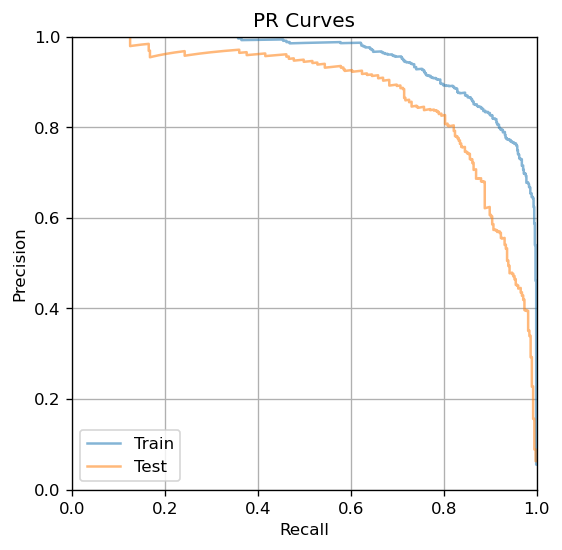

In [253]:
eval_prc(lgbm_model,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test[selected_feats],
         y_test=y_test)

**This improvement resulted in a cost reduction of as much as 2000 Euros!**

10060 0.01


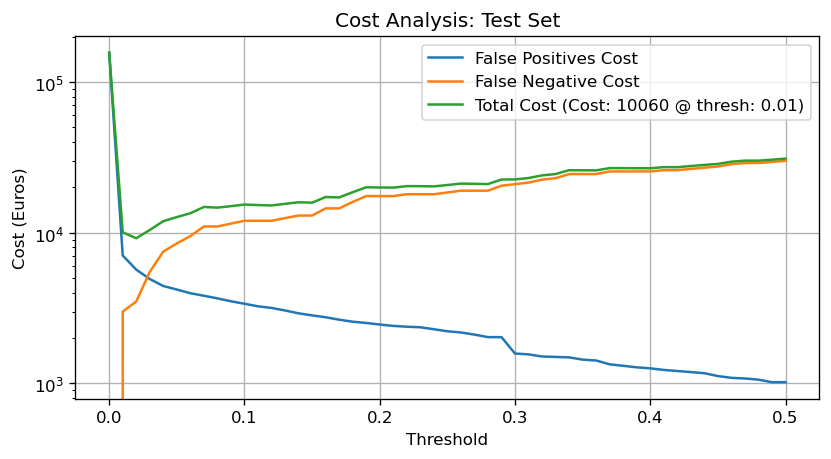

In [254]:
eval_thresh_cost(lgbm_model,
                 x=x_test[selected_feats],
                 y=y_test,
                 title='Cost Analysis: Test Set',
                 custom_thresh=0.01)

## Top Predictors of APS Failures

The top 20 predictor of APS failures are highlighted below along with the overall SHAP score and SHAP distribution. Here, we see that the top 5 predictors are variables that begin with "c" and end with "000".

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


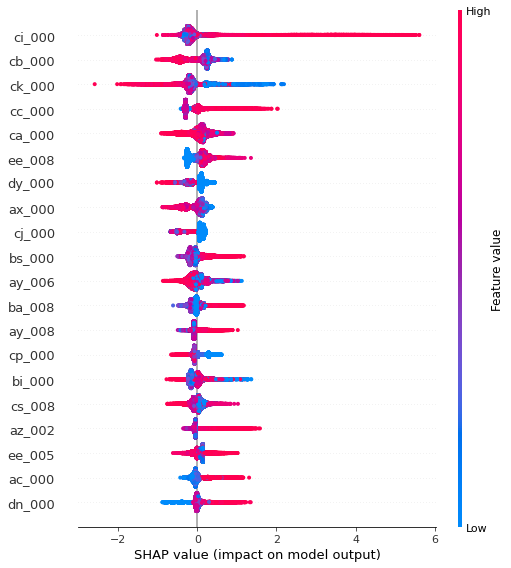

In [72]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[1], x_train)

,col_name,feature_importance_vals
24,ci_000,0.420947
14,cb_000,0.299664
28,ck_000,0.280465
17,cc_000,0.231554
55,ca_000,0.200569
...,...,...
33,ba_001,0.015470
31,cs_003,0.015002
4,dr_000,0.013895
16,dt_000,0.013146


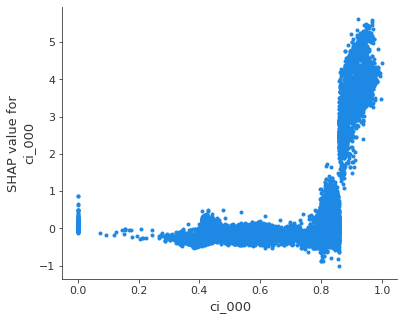

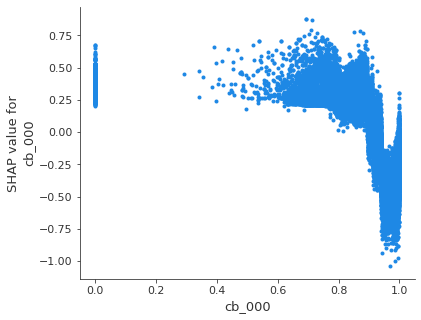

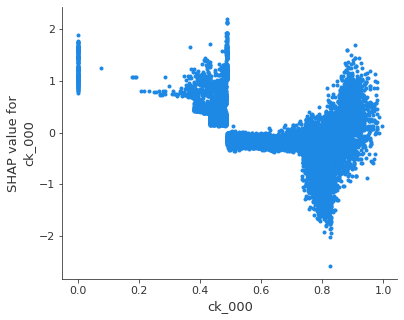

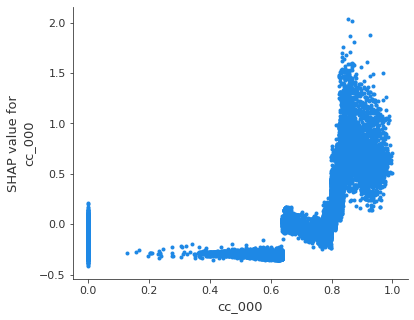

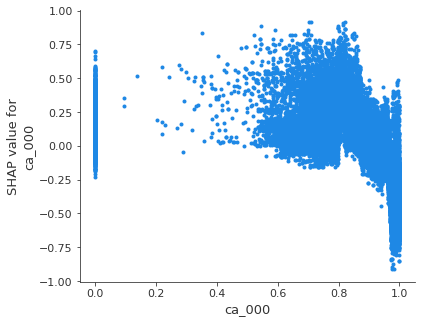

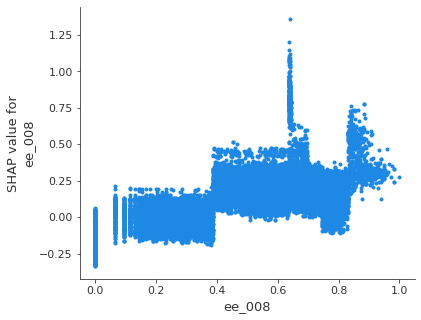

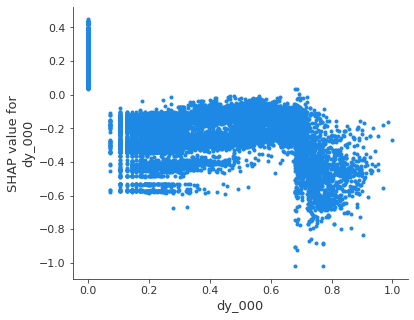

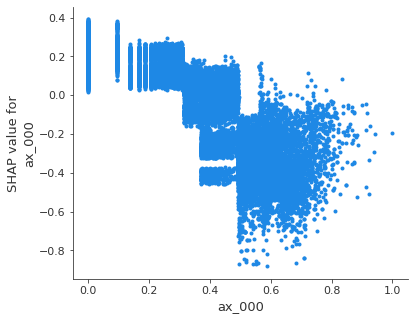

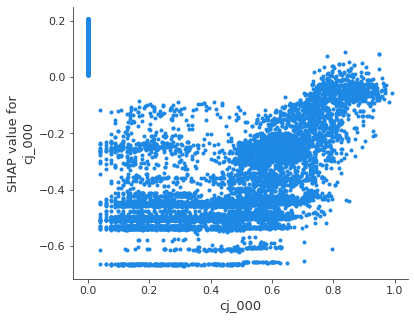

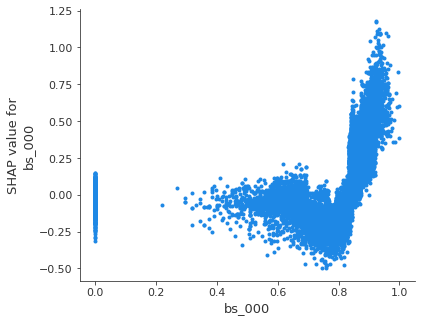

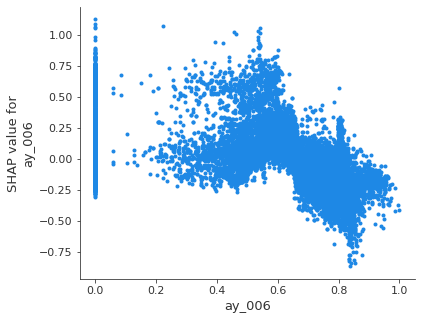

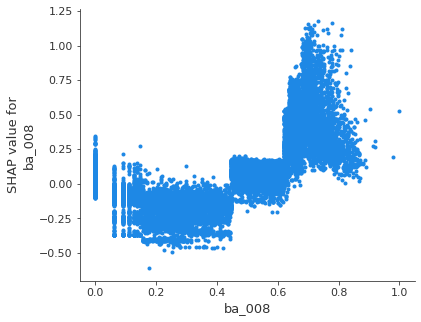

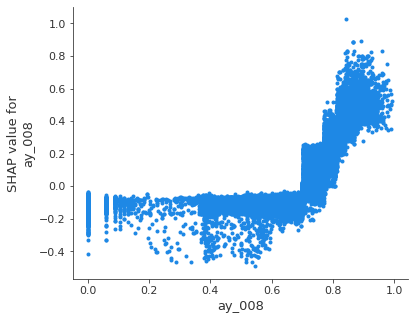

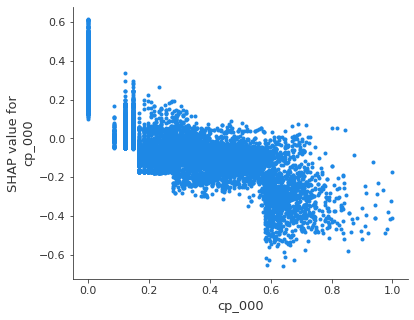

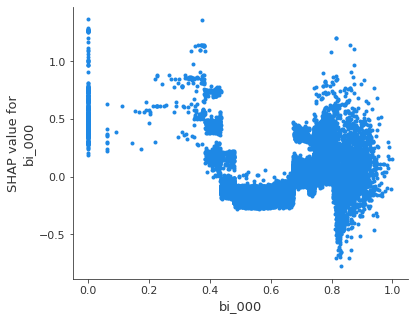

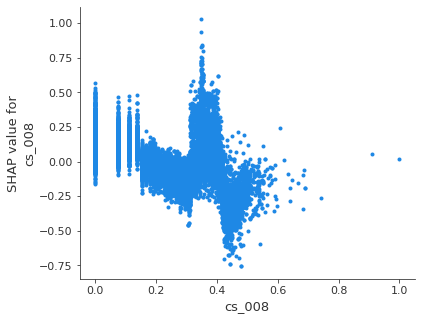

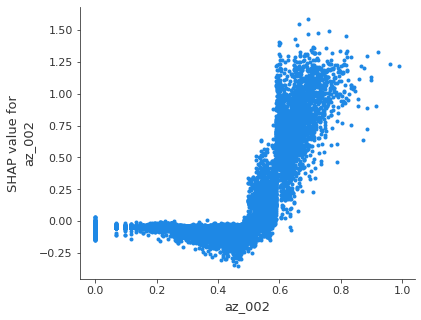

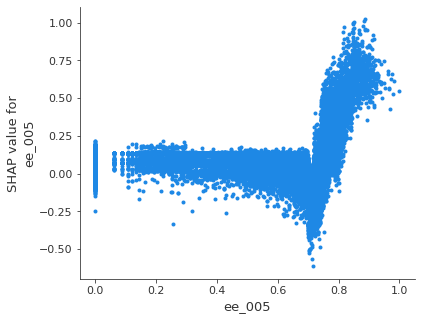

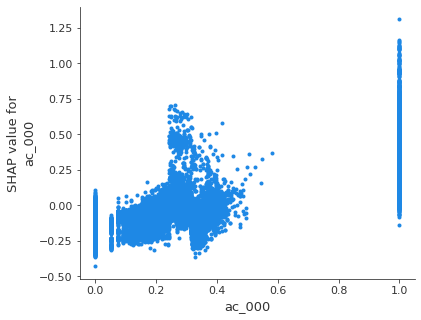

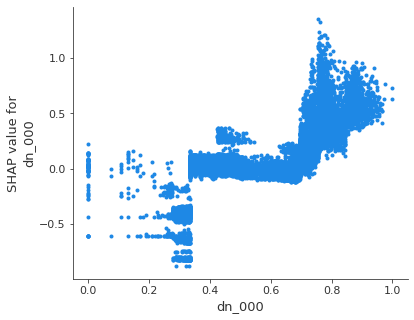

In [78]:
vals= np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),
                                  columns=['col_name',
                                           'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False,inplace=True)
display(feature_importance)

for feat in feature_importance.head(20)['col_name']:
    shap.dependence_plot(feat, shap_values[1], x_train, interaction_index=None)

## Result And Conclusion

We have successfully made a model that is capable of identifying if the APS system is at risk of failure or not and it has an estimated loss of around 10k Euros for the entire test set. This is a 90% reduction of losses when compared to an overly cautios approach (i.e. performing maintenance on every single datapoint in the test set - results to a loss of ~150k Euros). The top 5 predictors of failure are the masked variables: `ci_000`, `cb_000`, `ck_000`, `cc_000` and `ca_000`, wherein a higher value in any of these variables, indicate a a change (higher/lower) in the SHAP score.